In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import numpy as np

# Prevents crashes when showing graphs
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
SIM_STEPS = 201

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [13]:
# Pre-Determined train/test/val split
train_sims = np.load("../train_sims.npy")
train_sims = train_sims[train_sims < 750]
val_sims = np.load("../val_sims.npy")
val_sims = val_sims[val_sims < 750]
test_sims = np.load("../test_sims.npy")
test_sims = test_sims[test_sims < 750]

# Get porosity phi
def get_phi(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Image-{sim}-{step}_phi.jpg", cv2.IMREAD_GRAYSCALE)

# Get pressure
def get_pres(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Image-{sim}-{step}_P.jpg", cv2.IMREAD_GRAYSCALE)

# Get conductivity K
def get_k(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Image-{sim}-{step}_K.jpg", cv2.IMREAD_GRAYSCALE)

# Get all 3 as a 3-channel matrix
def get_all(sim,step):
    return np.array((get_k(sim,step), get_pres(sim,step), get_phi(sim,step)), dtype=np.float32)

In [14]:
# Darcy loss function
def darcy_loss(model, inp):
    # Takes in the k,pres,phi and outputs the prediction across the image.
    inp = inp.requires_grad_(True)
    out = model(inp)
    # out is in order K,P,phi, (conductivity, pressure, porosity)

    # Impose high pressure along the entire upper line by setting the pressure channelt to 200.
    out[:, 1:2, 0, :] = 200

    # If we assume the output is in order k,pres,phi
    # pres_grad is the gradient of the pressure along the y and x directions as a tuple
    pres_grad = torch.gradient(out[:, 1:2], dim=(-2,-1))

    # get velocity by multiplying the gradient by the conductivity
    y_grad = pres_grad[0] * out[:, 0:1]
    x_grad = pres_grad[1] * out[:, 0:1]

    # compute the divergence by the second derivative of the gradients and adding them together
    yy_grad = torch.gradient(y_grad, spacing=(1,),dim=(-2,))[0]
    xx_grad = torch.gradient(x_grad, spacing=(1,),dim=(-1,))[0]
    final = yy_grad + xx_grad

    # total divergence should be 0
    loss = (final**2).mean()

    return loss, out

In [15]:
# Building Blocks of the Unet

class TwoConv(nn.Module):
    # Basic block with 2 convolutional layers, each with a batch norm and relu
    
    def __init__(self, in_channels, out_channels, no_end_relu=False):
        super().__init__()
        
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        if no_end_relu:
            self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            )

    def forward(self, inp):
        return self.seq(inp)

# A single conv layer that will increase the height and width of the matrix by 2 each.
class SmallUp(nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = nn.Conv2d(channels, channels, 3, 1, 2)

    def forward(self, inp):
        return F.relu(self.conv(inp))

# A single conv layer that will decrease the height and width of the matrix by 2 each.
class SmallDown(nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = nn.Conv2d(channels, channels, 3, 1, 0)

    def forward(self, inp):
        return F.relu(self.conv(inp))
    
# Applies two convolutional layers, then pools
class Downsample(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = TwoConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, inp):

        return self.pool(self.conv(inp))

# Upsamples and concatenates the upsampled matrix with the "across" then performs convolution on the result
class Upsample(nn.Module):

    def __init__(self, in_channels, out_channels, tweak=None):
        super().__init__()
        # Upsamples by 2x
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1)
        self.tweak = tweak
        self.conv_after = TwoConv(in_channels, out_channels)

    def forward(self, below, across):
        # First upsample by 2x
        upsampled = self.up(below)
        # If tweak is active, apply it first
        if not self.tweak == None:
            upsampled = self.tweak(upsampled)
        # Concatenate with the same size on the downswing of the unet
        concat = torch.concat((upsampled, across), dim=-3)
        # Convolute them together
        return self.conv_after(concat)
    
# Define the actual model used
class SmallUnet(nn.Module):
    
    def __init__(self):
        super().__init__()

        # Input is Nx3x200x200
        self.c1 = TwoConv(3, 8)
        self.d1 = Downsample(8,16) # 16x100x100
        self.d2 = Downsample(16,32) # 32x50x50
        self.su = nn.Sequential(
            SmallUp(32),
            SmallUp(32),
            SmallUp(32)
        ) # 3x56x56
        self.d3 = Downsample(32,64) # 64x28x28
        self.d4 = Downsample(64,128) # 128x14x14
        self.d5 = Downsample(128, 256) # 256x7x7

        # Now back up
        self.u1 = Upsample(256, 128) # 128x14x14
        self.u2 = Upsample(128, 64) # 64x28x28
        self.u3 = Upsample(64, 32, tweak=nn.Sequential(
            SmallDown(32),
            SmallDown(32),
            SmallDown(32)
        ))  # 32x50x50
        self.u4 = Upsample(32,16) # 16x100x100
        self.u5 = Upsample(16,8) # 8x200x200
        self.final = TwoConv(8, 3, no_end_relu=True)

    def forward(self, input):
        # Start with convolution, expand 3 channels to 8.
        # Then downsample 5 times, saving the result
        top = self.c1(input)
        x1 = self.d1(top)
        x2 = self.d2(x1)
        x3 = self.d3(self.su(x2)) # Here we upsample slightly so that we can downsample with less border artifacts
        x4 = self.d4(x3)
        x5 = self.d5(x4)
        # Now that we're at 256x7x7, we upsample from here.
        # At each layer with concatenate with the xi that is the same size as the up after upsampling.
        up = self.u1(x5, x4)
        up = self.u2(up, x3)
        up = self.u3(up, x2) # Again, a small downsample here to get back on the proper resolution
        up = self.u4(up, x1)
        up = self.u5(up, top)
        # One last convolution on the result to return to 3 channels from 8, leaving us with the proper 3x200x200
        return self.final(up)

In [16]:
class MaskedDataset(torch.utils.data.Dataset):

    def __init__(self,
                 sims,
                 unmask_size=20,
                 points = None,
                 block_size = 50,
                 reveal_strategy = "block",
                 n_points = 200,
                 radius = 2,
                 steps = None,
                 H=200,
                 W=200,
                 channels="all",
                 mixed=False,
                 types=None,
                 noise=5,
                 return_mask=False,                 # allows visualiztion of mask
                 reveal_dim=[[(0, 1)], [(0, 1)]],   # x,y range for disks to exist
                 jitter_std=0.0,                    # % each disk drifts from deterministic position
                 deterministic_mask=True,            # if True, mask is deterministic and noise is 0
                 future_delta=0
                 ):
        
        self.sims = sims
        self.points = points
        self.steps = steps
        self.size = unmask_size
        self.reveal_strategy = reveal_strategy
        self.block_size = block_size
        self.n_points = n_points
        self.radius = radius
        self.H, self.W = H, W
        self.channels = channels
        self.mixed = mixed
        self.types = types
        self.noise = noise
        self.return_mask = return_mask
        self.reveal_dim = reveal_dim
        self.jitter_std = jitter_std
        self.deterministic_mask = deterministic_mask
        self.future_delta = future_delta

    def _chan_idx(self):
        if self.channels == "all":
            return [0,1,2]
        elif self.channels == "K":
            return [0]
        elif self.channels == "P":
            return [1]
        elif self.channels == "phi":
            return [2]
        else:
            raise ValueError("channels must be 'all', 'K', 'P', or 'phi'")

    
    

    def __getitem__(self, index):
        
        # --- In Progress --- 

            # pick a valid step
        if not isinstance(self.steps, np.ndarray):
            max_start = SIM_STEPS - 1 - self.future_delta  # ensures step + delta ≤ 199
            step = np.random.randint(1, max_start + 1)  
        else:
            step = int(self.steps[index])
            max_start = SIM_STEPS - 1 - self.future_delta
            if step > max_start:
                step = max_start



        # if not type(self.steps) == np.ndarray:
        #     step = np.random.randint(1,200)
        # else:
        #     step = self.steps[index]



        # Create tensor for the target
        t_cur = torch.tensor(get_all(self.sims[index], step), dtype=torch.float32)

        # Create 0 matrix
        z = torch.zeros_like(t_cur)

        # build a boolean mask of revealed pixels, shape (H,W)
        mask = torch.zeros((self.H, self.W), dtype=torch.bool)

        chans = self._chan_idx()

        if self.reveal_strategy == "block":
            # choose top-left for the block
            if not type(self.points) == np.ndarray:
                i0 = np.random.randint(0, self.H - self.block_size + 1)
                j0 = np.random.randint(0, self.W - self.block_size + 1)
            else:
                i0, j0 = self.points[index]
                i0 = max(0, min(i0, self.H - self.block_size))
                j0 = max(0, min(j0, self.W - self.block_size))
            mask[i0:i0+self.block_size, j0:j0+self.block_size] = True

        elif self.reveal_strategy == "disks":

            # used for reveal_dim
            # map fraction [0,1] to pixel indices [0, N-1] in mask layer
            def _segments_to_indices(segments, N, pad=0):
                idxs = []
                for a, b in segments:
                    i0 = max(pad, int(round(a * (N - 1))))
                    i1 = min((N - 1) - pad, int(round(b * (N - 1))))
                    if i1 >= i0:
                        idxs.append(torch.arange(i0, i1 + 1, dtype=torch.long))
                if not idxs:
                    # fallback to full range
                    return torch.arange(pad, N - pad, dtype=torch.long)
                return torch.unique(torch.cat(idxs)).to(torch.long)

            row_fracs = self.reveal_dim[0] # e.g, [(0, 1)]
            col_fracs = self.reveal_dim[1] # e.g, [(0, 1)]
            row_allowed = _segments_to_indices(row_fracs, self.H, pad=self.radius)
            col_allowed = _segments_to_indices(col_fracs, self.W, pad=self.radius)

            # choose grid shape close to aspect ratio 
            # works with non-squares
            Hspan = (row_allowed[-1] - row_allowed[0] + 1) if len(row_allowed) > 0 else self.H
            Wspan = (col_allowed[-1] - col_allowed[0] + 1) if len(col_allowed) > 0 else self.W
            ratio = float(Wspan) / max(1.0, float(Hspan))
            ny = int(max(1, round(np.sqrt(self.n_points / max(1e-8, ratio)))))
            nx = int(max(1, round(self.n_points / ny)))
            while nx * ny < self.n_points:
                nx += 1

            # pick evenly spaced indices from rows/cols allowed
            def pick_lin_indices(allowed, k):
                if k <= 1:
                    return allowed[len(allowed)//2]
                pos = torch.linspace(0, len(allowed)-1, steps=k)
                idx = torch.round(pos).long()
                return allowed[idx]
            
            
            row_picks = pick_lin_indices(row_allowed, ny)
            col_picks = pick_lin_indices(col_allowed, nx)
            yy, xx = torch.meshgrid(row_picks, col_picks, indexing="ij")
            points = torch.stack([yy.reshape(-1), xx.reshape(-1)], dim=1) # (ny*nx, 2)
            
            # if more than n_points, subselect
            if points.shape[0] > self.n_points:
                sel_pos = torch.linspace(0, points.shape[0]-1, steps=self.n_points)
                sel_idx = torch.round(sel_pos).long()
                points = points[sel_idx]

            ii = points[:, 0]
            jj = points[:, 1]

            if not self.deterministic_mask:
                if self.jitter_std is not None and self.jitter_std > 0:
                    # convert std (like 0.01 of image size) to pixels
                    sigmaH = float(self.jitter_std) * self.H
                    sigmaW = float(self.jitter_std) * self.W
                    
                    # Add Gaussian noise in pixel units
                    ii = ii.to(torch.float32) + torch.randn_like(ii, dtype=torch.float32) * sigmaH
                    jj = jj.to(torch.float32) + torch.randn_like(jj, dtype=torch.float32) * sigmaW

                    # Round and clamp so they stay inside bounds
                    ii = ii.round().clamp(self.radius, self.H - 1 - self.radius).to(torch.long)
                    jj = jj.round().clamp(self.radius, self.W - 1 - self.radius).to(torch.long)




            yy, xx = torch.meshgrid(torch.arange(self.H), torch.arange(self.W), indexing="ij")
            for y0, x0 in zip(ii, jj):
                disk = (yy - int(y0))**2 + (xx - int(x0))**2 <= (self.radius**2)
                mask |= disk
        else:
            raise ValueError(f"Unknown reveal_strategy: {self.reveal_strategy}")
        

        obs = t_cur[chans].clone()
        # Add noise (0 - 255 scale)
        if self.noise is not None and self.noise > 0:
            sigma = float(self.noise)
            obs = obs + sigma * torch.randn_like(obs)
            obs.clamp_(0.0, 255.0)


        z[chans, :, :] = torch.where(mask, obs, torch.zeros_like(obs))








        # --- In Progress --- 

        if self.future_delta > 0:
            step_f = step + self.future_delta   
            t_label = torch.tensor(get_all(self.sims[index], step_f), dtype=torch.float32)
        else:
            t_label = t_cur.clone()



        if self.return_mask:
            return z,t_label, mask
        else:  
            return z,t_label
    
    def __len__(self):
        return self.sims.shape[0]


In [17]:
def make_sample_for_sim_time(sim_id, t, meta, future_delta):
    """
    Build a single (z, t_label) pair for a specific sim and time t
    using the same config that was used during training.
    """
    reveal_strategy    = str(meta["reveal_strategy"])
    n_points           = int(meta["n_points"])
    radius             = int(meta["radius"])
    noise              = float(meta["noise"])
    channels           = meta["channels"]
    reveal_dim         = meta["reveal_dim"].tolist() if hasattr(meta["reveal_dim"], "tolist") else meta["reveal_dim"]
    deterministic_mask = bool(meta["deterministic_mask_val"])
    jitter_std         = float(meta["jitter_std_val"])
    mixed              = bool(meta["mixed"])

    # make sure t is valid for this delta
    SIM_STEPS = 201
    max_start = SIM_STEPS - 1 - future_delta   # same logic as in MaskedDataset
    t = min(int(t), max_start)

    ds = MaskedDataset(
        sims=np.array([sim_id]),
        reveal_strategy=reveal_strategy,
        n_points=n_points,
        radius=radius,
        noise=noise,
        channels=channels,
        points=None,                         # let it pick mask positions
        steps=np.array([t]),                 # <- force time t
        reveal_dim=reveal_dim,
        deterministic_mask=deterministic_mask,
        jitter_std=jitter_std,
        mixed=mixed,
        future_delta=future_delta,
    )

    z, t_label = ds[0]   # only one sample
    return z, t_label, t

In [18]:
import numpy as np
import torch
from collections import defaultdict

def _side_label_and_margin(img2d, top_rows=40, eps=1e-6, min_total=1e3):
    """
    Given a 2D array img2d (H x W), look only at the top `top_rows`,
    sum left vs right half, and return:
      - side: 0 for left, 1 for right
      - margin: |L-R| / (L+R+eps)
      - total: L+R
    If the total mass is too small, returns (None, None, total).
    """
    img = np.asarray(img2d)
    H, W = img.shape

    rmax = min(top_rows, H)
    strip = img[:rmax, :]

    mid = W // 2
    left_sum  = float(strip[:, :mid].sum())
    right_sum = float(strip[:, mid:].sum())
    total     = left_sum + right_sum

    if total < min_total:
        # basically no structure here -> skip this trial as "no channel yet"
        return None, None, total

    if left_sum > right_sum:
        side = 0
    elif right_sum > left_sum:
        side = 1
    else:
        # perfectly equal – extremely rare, but treat as ambiguous
        return None, None, total

    margin = abs(left_sum - right_sum) / (total + eps)
    return side, margin, total

In [19]:
def left_right_stats_for_one_model(
    name,
    base_path="",
    sims=None,              # list/array of sim IDs to evaluate; if None, use val_sims
    time_range=(85, 110),   # start times t to test
    channel=0,              # which channel to use for side (0=K, 1=P, 2=phi)
    top_rows=40,            # how far down from top to look
    gt_margin_thresh=0.10,  # what counts as a "strong" GT left/right decision
    min_total=1e3           # min intensity to treat as valid (avoid totally blank/no erosion)
):
    """
    Computes a bunch of stats for a single model:
      - overall accuracy (all usable trials)
      - strong-case accuracy (where GT channel decisively chose a side)
      - per-time accuracies
      - per-sim accuracies
      - counts of skipped / ambiguous trials
    """

    # ----- load meta + model -----
    meta_path  = f"{base_path}meta_{name}.npz"
    model_path = f"{base_path}{name}.pt"

    meta  = np.load(meta_path, allow_pickle=True)
    model = torch.load(model_path, weights_only=False,
                       map_location=torch.device("cpu")).to(device)
    model.eval()

    # future_delta from meta if present
    if "future_delta" in meta.files:
        future_delta = int(meta["future_delta"])
    else:
        # fallback: infer from naming or assign manually
        # e.g., if name is "full_d40_n16_clean"
        import re
        m = re.search(r"d(\d+)", name)
        future_delta = int(m.group(1)) if m else 0

    # which sims to use
    global val_sims  # assumes val_sims is defined in your notebook
    if sims is None:
        sims_to_use = np.unique(val_sims)
    else:
        sims_to_use = np.array(sims, dtype=int)

    t_min, t_max = time_range

    # ----- accumulators -----
    total_trials_all   = 0
    total_correct_all  = 0

    total_trials_strong  = 0
    total_correct_strong = 0

    total_skipped_low_mass = 0
    total_ambiguous_gt     = 0

    # per-time accumulators
    time_correct_all   = defaultdict(int)
    time_total_all     = defaultdict(int)
    time_correct_strong= defaultdict(int)
    time_total_strong  = defaultdict(int)

    # per-sim accumulators
    sim_correct_all   = defaultdict(int)
    sim_total_all     = defaultdict(int)
    sim_correct_strong= defaultdict(int)
    sim_total_strong  = defaultdict(int)

    # ----- main loop -----
    for sim in sims_to_use:
        for t in range(t_min, t_max + 1):
            t_future = t + future_delta
            if t_future >= SIM_STEPS:
                # can't evaluate beyond the end of simulation
                continue

            # build sample at (sim, t)
            # expected: z, t_label, t0 = make_sample_for_sim_time(sim, t, meta, future_delta)
            sample = make_sample_for_sim_time(sim, t, meta, future_delta)
            if len(sample) == 3:
                z, t_label, _t0 = sample
            else:
                z, t_label = sample
                _t0 = t  # fallback

            # model prediction for future
            with torch.no_grad():
                out = model(z.to(device).unsqueeze(0))[0].cpu().numpy()  # (C,H,W)
            t_label_np = t_label.cpu().numpy() if isinstance(t_label, torch.Tensor) else np.asarray(t_label)

            gt_img   = t_label_np[channel]  # future true
            pred_img = out[channel]         # future predicted

            # --- GT side & margin ---
            gt_side, gt_margin, gt_total = _side_label_and_margin(
                gt_img, top_rows=top_rows, min_total=min_total
            )
            if gt_side is None:
                # either not enough total energy, or perfectly equal sides
                if gt_total < min_total:
                    total_skipped_low_mass += 1
                else:
                    total_ambiguous_gt     += 1
                continue

            # --- predicted side (we don't threshold margin here for correctness) ---
            pred_side, pred_margin, pred_total = _side_label_and_margin(
                pred_img, top_rows=top_rows, min_total=0.0
            )
            if pred_side is None:
                # model produced something basically empty / symmetric on top rows
                pred_side = 0  # arbitrary, but we still treat it as a prediction

            # record trial
            total_trials_all += 1
            if pred_side == gt_side:
                total_correct_all += 1
                time_correct_all[t] += 1
                sim_correct_all[int(sim)] += 1
            time_total_all[t] += 1
            sim_total_all[int(sim)] += 1

            # strong-case?
            if gt_margin >= gt_margin_thresh:
                total_trials_strong += 1
                time_total_strong[t] += 1
                sim_total_strong[int(sim)] += 1

                if pred_side == gt_side:
                    total_correct_strong += 1
                    time_correct_strong[t] += 1
                    sim_correct_strong[int(sim)] += 1

    # ---- aggregate stats ----
    acc_all = total_correct_all / total_trials_all if total_trials_all > 0 else np.nan
    acc_strong = (
        total_correct_strong / total_trials_strong
        if total_trials_strong > 0 else np.nan
    )

    # per-time arrays
    times_sorted = sorted(time_total_all.keys())
    acc_all_time    = []
    acc_strong_time = []
    count_all_time  = []
    count_strong_time = []

    for t in times_sorted:
        ca = time_correct_all[t]
        ta = time_total_all[t]
        cs = time_correct_strong[t]
        ts = time_total_strong[t]
        acc_all_time.append(ca / ta if ta > 0 else np.nan)
        acc_strong_time.append(cs / ts if ts > 0 else np.nan)
        count_all_time.append(ta)
        count_strong_time.append(ts)

    # per-sim stats
    sims_sorted = sorted(sim_total_all.keys())
    sim_stats = []
    for s in sims_sorted:
        ta = sim_total_all[s]
        ca = sim_correct_all[s]
        ts = sim_total_strong[s]
        cs = sim_correct_strong[s]
        sim_stats.append({
            "sim": int(s),
            "acc_all":   ca / ta if ta > 0 else np.nan,
            "acc_strong":cs / ts if ts > 0 else np.nan,
            "trials_all":   ta,
            "trials_strong":ts,
        })

    return {
        "model_name": name,
        "future_delta": future_delta,
        "accuracy_all": acc_all,
        "accuracy_strong": acc_strong,
        "total_trials_all": total_trials_all,
        "total_trials_strong": total_trials_strong,
        "skipped_low_mass": total_skipped_low_mass,
        "ambiguous_gt": total_ambiguous_gt,
        "time_curve": {
            "t_values": np.array(times_sorted, dtype=int),
            "acc_all": np.array(acc_all_time, dtype=float),
            "acc_strong": np.array(acc_strong_time, dtype=float),
            "count_all": np.array(count_all_time, dtype=int),
            "count_strong": np.array(count_strong_time, dtype=int),
        },
        "sim_stats": sim_stats,
    }

In [20]:
def eval_and_print_left_right(
    name,
    base_path="",
    sims=None,
    time_range=(85, 110),
    channel=0,
    top_rows=40,
    gt_margin_thresh=0.10,
    min_total=1e3,
):
    stats = left_right_stats_for_one_model(
        name=name,
        base_path=base_path,
        sims=sims,
        time_range=time_range,
        channel=channel,
        top_rows=top_rows,
        gt_margin_thresh=gt_margin_thresh,
        min_total=min_total,
    )

    print(f"Model: {stats['model_name']}")
    print(f"  Δ = {stats['future_delta']}")
    print(f"  Accuracy (all trials):    {stats['accuracy_all']:.3f} "
          f"over {stats['total_trials_all']} trials")
    print(f"  Accuracy (strong GT ≥ {gt_margin_thresh:.2f}): "
          f"{stats['accuracy_strong']:.3f} over {stats['total_trials_strong']} trials")
    print(f"  Skipped (low mass): {stats['skipped_low_mass']}, "
          f"Ambiguous GT: {stats['ambiguous_gt']}")
    print()

    return stats

In [28]:
vals = range(140)
f_delta_values = list(vals[::6])
print(f_delta_values)

tests = [
    {
        "name": f"full_d{d}_n16_clean",
        "reveal_strategy": "disks",
        "n_points": 16,
        "radius": 5,
        "mixed": False,
        "noise": 0, 
        "deterministic_mask": False,
        "jitter_std": 0.02,
        "reveal_dim": [[(0.2, .8)],[(.2,.8)]],
        "future_delta": d,
    }
    for d in f_delta_values
]

[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138]


In [22]:
for test in tests:
    name = test["name"]
    # Example: evaluate one model
    stats_d40 = eval_and_print_left_right(
        name,
        base_path="",
        sims=None,              # or e.g. val_sims[:100]
        time_range=(85, 110),
        channel=0,              # or 2 if phi is clearer
        top_rows=40,
        gt_margin_thresh=0.10,
    )

Model: full_d0_n16_clean
  Δ = 0
  Accuracy (all trials):    0.922 over 2964 trials
  Accuracy (strong GT ≥ 0.10): 0.995 over 1908 trials
  Skipped (low mass): 0, Ambiguous GT: 0

Model: full_d2_n16_clean
  Δ = 2
  Accuracy (all trials):    0.924 over 2964 trials
  Accuracy (strong GT ≥ 0.10): 0.998 over 2085 trials
  Skipped (low mass): 0, Ambiguous GT: 0

Model: full_d4_n16_clean
  Δ = 4
  Accuracy (all trials):    0.831 over 2964 trials
  Accuracy (strong GT ≥ 0.10): 0.906 over 2241 trials
  Skipped (low mass): 0, Ambiguous GT: 0



KeyboardInterrupt: 

In [24]:
import numpy as np
import torch

def side_from_image(img, channel=0, top_rows=40, min_mass=1e-3):
    """
    Decide whether the channel is more on the left or right in the top part
    of the image.

    img: (C, H, W) numpy array or torch tensor
    channel: which channel to look at (0=K, 1=P, 2=phi)
    top_rows: only look at rows [0:top_rows] to focus on the inlet region
    min_mass: if total intensity is below this, treat as 'too weak'
    """
    if torch.is_tensor(img):
        arr = img.detach().cpu().numpy()
    else:
        arr = np.asarray(img)

    C, H, W = arr.shape
    top_rows = min(top_rows, H)

    patch = arr[channel, :top_rows, :]          # (top_rows, W)

    left_mass  = patch[:, :W//2].sum()
    right_mass = patch[:, W//2:].sum()
    total      = left_mass + right_mass

    if total < min_mass:
        # essentially no channel signal -> skip
        return None, 0.0, total

    margin = abs(left_mass - right_mass) / max(total, 1e-8)
    side   = "L" if left_mass > right_mass else "R"

    return side, margin, total

In [25]:
def left_right_accuracy_over_time(
    model_name,
    base_path="",
    future_delta=None,        # if None, read from meta
    time_values=None,         # list of times t to evaluate
    channel=0,                # 0=K, 1=P, 2=phi (for deciding side)
    top_rows=40,
    min_mass=1e-3,
    strong_margin=0.10,       # margin threshold for “strong GT”
    max_sims=None,            # limit sims for speed
):
    """
    For a single trained model, compute directional accuracy (left vs right)
    as a function of the start time t.

    Returns a dict with:
      times, acc_all, acc_strong, n_all, n_strong,
      n_lowmass, n_ambig, future_delta
    """
    # ---- load meta + model ----
    meta_path  = f"{base_path}meta_{model_name}.npz"
    model_path = f"{base_path}{model_name}.pt"

    meta  = np.load(meta_path, allow_pickle=True)
    model = torch.load(model_path, weights_only=False,
                       map_location=torch.device("cpu")).to(device)
    model.eval()

    # get Δ
    if future_delta is None:
        future_delta = int(meta["future_delta"]) if "future_delta" in meta.files else 0

    # which sims to use
    sims = val_sims.copy()
    if max_sims is not None:
        sims = sims[:max_sims]

    # default time grid if not given
    if time_values is None:
        # e.g. from 60 to 140 in steps of 5
        time_values = list(range(60, 141, 5))

    results = {
        "times": [],
        "acc_all": [],
        "acc_strong": [],
        "n_all": [],
        "n_strong": [],
        "n_lowmass": [],
        "n_ambig": [],
        "future_delta": future_delta,
    }

    for t in time_values:
        # skip times whose future t+Δ goes past the end
        if t + future_delta >= SIM_STEPS:
            continue

        correct_all = total_all = 0
        correct_str = total_str = 0
        n_lowmass = 0
        n_ambig   = 0

        for sim_id in sims:
            sim_id = int(sim_id)

            # build masked input at time t using your same meta config
            z, t_label, t_actual = make_sample_for_sim_time(sim_id, t, meta, future_delta)

            t_f = t + future_delta

            # ground-truth future (from raw data)
            img_true_future = get_all(sim_id, t_f)    # (3, H, W)

            # model prediction
            with torch.no_grad():
                out = model(z.to(device).unsqueeze(0))[0]
            img_pred_future = out.detach().cpu().numpy()  # (3, H, W)

            # ---- decide L/R for GT ----
            side_true, margin_true, mass_true = side_from_image(
                img_true_future,
                channel=channel,
                top_rows=top_rows,
                min_mass=min_mass,
            )

            if side_true is None:
                # too little signal -> low mass
                n_lowmass += 1
                continue

            # ---- decide L/R for prediction ----
            side_pred, margin_pred, mass_pred = side_from_image(
                img_pred_future,
                channel=channel,
                top_rows=top_rows,
                min_mass=min_mass,
            )

            if side_pred is None:
                # model predicted nothing meaningful: count as trial, but incorrect
                total_all += 1
                # not strong GT if margin below threshold
                if margin_true >= strong_margin:
                    total_str += 1
                continue

            # classify GT as strong vs ambiguous
            is_strong = (margin_true >= strong_margin)
            is_ambig  = (margin_true < strong_margin)

            total_all += 1
            if side_pred == side_true:
                correct_all += 1

            if is_strong:
                total_str += 1
                if side_pred == side_true:
                    correct_str += 1
            else:
                n_ambig += 1

        acc_all = np.nan if total_all == 0 else correct_all / total_all
        acc_str = np.nan if total_str == 0 else correct_str / total_str

        results["times"].append(t)
        results["acc_all"].append(acc_all)
        results["acc_strong"].append(acc_str)
        results["n_all"].append(total_all)
        results["n_strong"].append(total_str)
        results["n_lowmass"].append(n_lowmass)
        results["n_ambig"].append(n_ambig)

        print(
            f"[{model_name}] t={t:3d}, Δ={future_delta:3d} | "
            f"acc_all={acc_all:.3f} (n={total_all}), "
            f"acc_strong={acc_str:.3f} (n_str={total_str}), "
            f"lowmass={n_lowmass}, ambig={n_ambig}"
        )

    return results

In [ ]:
def left_right_accuracy_over_time(
    name,
    base_path="",
    future_delta=None,
    time_values=None,
    channel=0,
    top_rows=40,
    strong_margin=0.10,
    max_sims=250,
):
    """
    For a single model `name`, compute left/right accuracy as a function of start time t.
    Returns a dict containing arrays you can plot.
    """
    import numpy as np
    import torch

    meta_path   = f"{base_path}meta_{name}.npz"
    model_path  = f"{base_path}{name}.pt"

    meta  = np.load(meta_path, allow_pickle=True)
    model = torch.load(model_path, weights_only=False,
                       map_location=torch.device("cpu")).to(device)
    model.eval()

    # read Δ from meta unless overridden
    if future_delta is None:
        future_delta = int(meta["future_delta"]) if "future_delta" in meta.files else 0

    # if no specific times passed, fall back to a default grid
    if time_values is None:
        if future_delta <= 10:
            time_values = list(range(80, 121, 5))
        elif future_delta <= 40:
            time_values = list(range(60, 121, 5))
        else:
            time_values = list(range(30, 121, 5))

    # build val dataset (we only need sims list + meta for make_sample_for_sim_time)
    val_data = build_val_dataset_from_meta(meta)
    # val_data.sims is assumed to contain the sim IDs
    sims = val_data.sims
    if max_sims is not None and len(sims) > max_sims:
        sims = sims[:max_sims]

    t_list          = []
    acc_all_list    = []
    acc_strong_list = []
    n_all_list      = []
    n_strong_list   = []
    frac_strong_list= []

    for t in time_values:
        correct_all   = 0
        n_all         = 0
        correct_str   = 0
        n_strong      = 0
        ambiguous_gt  = 0
        low_mass      = 0

        for sim in sims:
            # sample input/label for this (sim, t)
            z, t_label, t_eff = make_sample_for_sim_time(sim, t, meta, future_delta)
            # effective future time
            t_f = min(SIM_STEPS - 1, t_eff + future_delta)

            # get actual future frame (ground truth)
            gt_all = get_all(sim, t_f)  # shape (C, H, W)
            gt_top = gt_all[channel, :top_rows, :]

            # classify GT side (left/right) and margin strength
            gt_left_mass  = gt_top[:, : gt_top.shape[1] // 2].sum()
            gt_right_mass = gt_top[:, gt_top.shape[1] // 2 :].sum()
            gt_total      = gt_left_mass + gt_right_mass

            if gt_total <= 1e-6:
                # almost no mass in the top layer: skip as low-mass
                low_mass += 1
                continue

            gt_left_frac  = gt_left_mass / gt_total
            gt_right_frac = gt_right_mass / gt_total
            gt_margin     = abs(gt_left_frac - gt_right_frac)

            if gt_margin < 0.05:
                # nearly symmetric: ambiguous ground truth
                ambiguous_gt += 1
                continue

            gt_label = 0 if gt_left_frac > gt_right_frac else 1

            # run model
            with torch.no_grad():
                out = model(z.to(device).unsqueeze(0))[0]  # (C, H, W)
            pred_top = out[channel, :top_rows, :].detach().cpu().numpy()

            pred_left_mass  = pred_top[:, : pred_top.shape[1] // 2].sum()
            pred_right_mass = pred_top[:, pred_top.shape[1] // 2 :].sum()
            pred_total      = pred_left_mass + pred_right_mass
            if pred_total <= 1e-6:
                # degenerate prediction? treat as wrong
                n_all += 1
                continue

            pred_left_frac  = pred_left_mass / pred_total
            pred_right_frac = pred_right_mass / pred_total
            pred_label      = 0 if pred_left_frac > pred_right_frac else 1

            # overall correctness
            n_all += 1
            if pred_label == gt_label:
                correct_all += 1

            # strong-case correctness (GT direction is clear)
            if gt_margin >= strong_margin:
                n_strong += 1
                if pred_label == gt_label:
                    correct_str += 1

        # compute accuracies
        acc_all   = correct_all / n_all if n_all > 0 else float("nan")
        acc_str   = correct_str / n_strong if n_strong > 0 else float("nan")
        frac_str  = n_strong / n_all if n_all > 0 else 0.0

        print(f"[{name}] t={t:3d}, Δ={future_delta:3d} | "
              f"acc_all={acc_all:.3f} (n={n_all}), "
              f"acc_strong={acc_str:.3f} (n_str={n_strong}), "
              f"lowmass={low_mass}, ambig={ambiguous_gt}")

        t_list.append(t)
        acc_all_list.append(acc_all)
        acc_strong_list.append(acc_str)
        n_all_list.append(n_all)
        n_strong_list.append(n_strong)
        frac_strong_list.append(frac_str)

    return {
        "model_name":    name,
        "future_delta":  future_delta,
        "t_values":      np.array(t_list),
        "acc_all":       np.array(acc_all_list),
        "acc_strong":    np.array(acc_strong_list),
        "n_all":         np.array(n_all_list),
        "n_strong":      np.array(n_strong_list),
        "frac_strong":   np.array(frac_strong_list),
    }

In [27]:
import matplotlib.pyplot as plt

def plot_lr_accuracy_curves(model_names, base_path="", time_values=None,
                            channel=0, top_rows=40, strong_margin=0.10,
                            max_sims=250):
    """
    model_names: list of strings, e.g. ["full_d0_n16_clean", "full_d20_n16_clean", ...]
    """
    plt.figure(figsize=(8,5))

    all_results = {}

    for name in model_names:
        print(f"\n=== Evaluating left/right vs time for {name} ===")
        res = left_right_accuracy_over_time(
            name,
            base_path=base_path,
            future_delta=None,          # read from meta
            time_values=time_values,    # you can pass something like range(70,121,5)
            channel=channel,
            top_rows=top_rows,
            strong_margin=strong_margin,
            max_sims=max_sims,
        )
        all_results[name] = res

        ts   = np.array(res["times"])
        accs = np.array(res["acc_strong"])   # I’d plot strong GT for clarity

        Δ = res["future_delta"]
        plt.plot(ts, accs, "-o", label=f"Δ={Δ}")

    plt.xlabel("Start time t")
    plt.ylabel("Directional accuracy (strong GT)")
    plt.title("Left/right prediction vs time for different Δ")
    plt.ylim(0, 1.05)
    plt.grid(True, alpha=0.3)
    plt.legend(title="Future Δ")
    plt.tight_layout()
    plt.show()

    return all_results

In [30]:
import os

for cfg in tests:
    name = cfg["name"]
    Δ    = cfg["future_delta"]

    # Required files for evaluation
    model_path = f"{name}.pt"
    meta_path  = f"meta_{name}.npz"

    # Check if both files exist
    if not os.path.exists(model_path):
        print(f"🚫 Skipping {name} — model file not found ({model_path})")
        continue
    if not os.path.exists(meta_path):
        print(f"🚫 Skipping {name} — meta file not found ({meta_path})")
        continue

    # Assign time grid based on future_delta
    if Δ <= 10:
        time_grid = list(range(80, 121, 5))   # short-horizon
    elif Δ <= 40:
        time_grid = list(range(60, 121, 5))   # medium-horizon
    else:
        time_grid = list(range(30, 121, 5))   # long-horizon

    print(f"➡ Evaluating {name} (Δ={Δ}) over times {time_grid}...")

    res = left_right_accuracy_over_time(
        name,
        base_path="",
        future_delta=None,      # read from meta
        time_values=time_grid,  # customized per Δ
        channel=0,
        top_rows=40,
        strong_margin=0.10,
        max_sims=250,
    )

    print(f"Done. Accuracy summary: {res.get('accuracy_summary', 'See metrics output')}")
    print("-" * 50)

➡ Evaluating full_d0_n16_clean (Δ=0) over times [80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d0_n16_clean] t= 80, Δ=  0 | acc_all=0.763 (n=114), acc_strong=1.000 (n_str=1), lowmass=0, ambig=113
[full_d0_n16_clean] t= 85, Δ=  0 | acc_all=0.781 (n=114), acc_strong=1.000 (n_str=16), lowmass=0, ambig=98
[full_d0_n16_clean] t= 90, Δ=  0 | acc_all=0.877 (n=114), acc_strong=1.000 (n_str=40), lowmass=0, ambig=74
[full_d0_n16_clean] t= 95, Δ=  0 | acc_all=0.939 (n=114), acc_strong=1.000 (n_str=69), lowmass=0, ambig=45
[full_d0_n16_clean] t=100, Δ=  0 | acc_all=0.974 (n=114), acc_strong=1.000 (n_str=92), lowmass=0, ambig=22
[full_d0_n16_clean] t=105, Δ=  0 | acc_all=0.974 (n=114), acc_strong=0.990 (n_str=103), lowmass=0, ambig=11
[full_d0_n16_clean] t=110, Δ=  0 | acc_all=0.974 (n=114), acc_strong=0.990 (n_str=104), lowmass=0, ambig=10
[full_d0_n16_clean] t=115, Δ=  0 | acc_all=0.991 (n=114), acc_strong=0.991 (n_str=107), lowmass=0, ambig=7
[full_d0_n16_clean] t=120, Δ=  0 | acc_all=0.965 

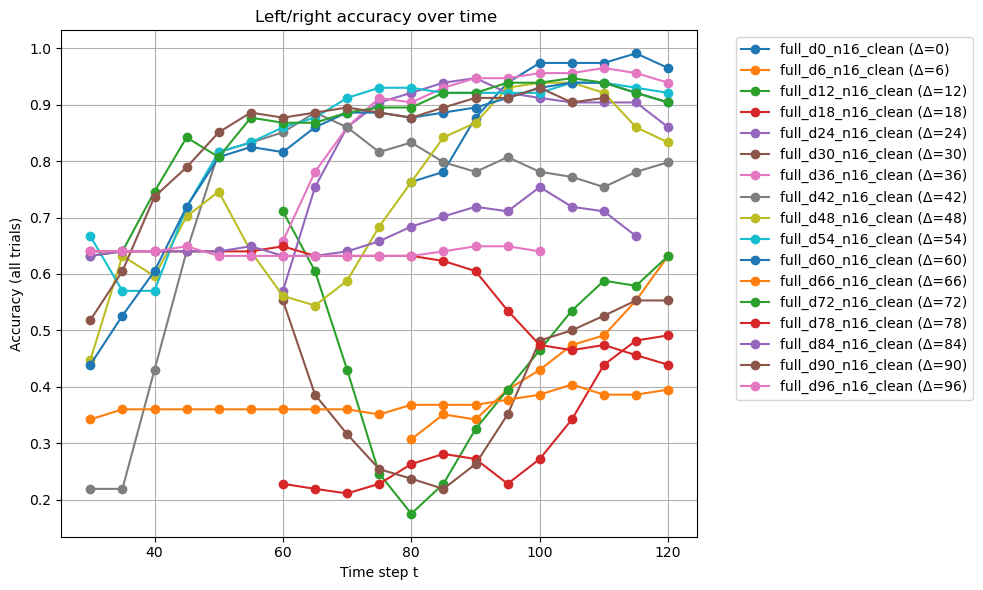

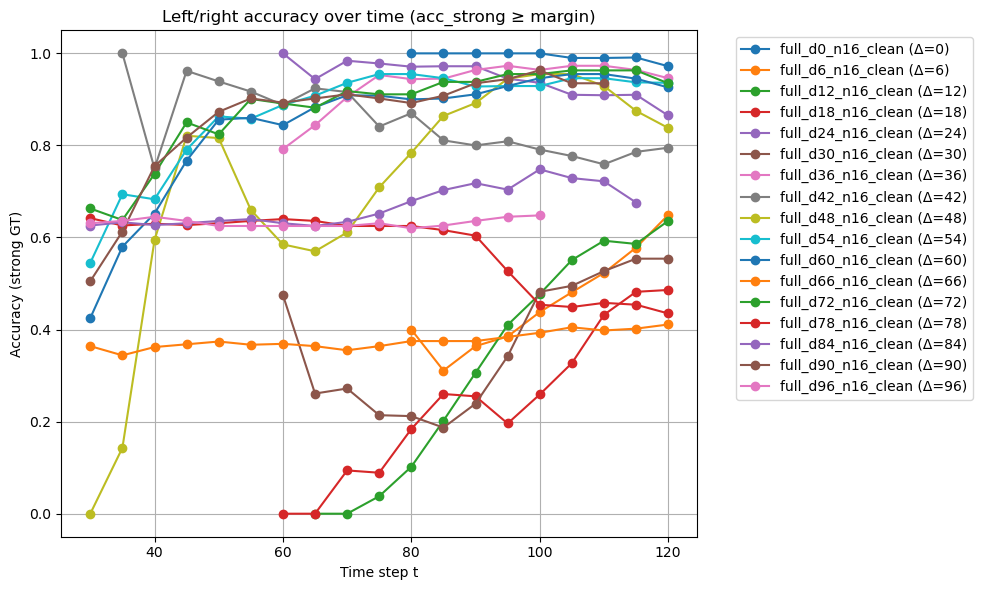

In [9]:
import re
import math
import matplotlib.pyplot as plt

# 🔹 1. Paste your full log here
log_text = """
[full_d0_n16_clean] t= 80, Δ=  0 | acc_all=0.763 (n=114), acc_strong=1.000 (n_str=1), lowmass=0, ambig=113
[full_d0_n16_clean] t= 85, Δ=  0 | acc_all=0.781 (n=114), acc_strong=1.000 (n_str=16), lowmass=0, ambig=98
[full_d0_n16_clean] t= 90, Δ=  0 | acc_all=0.877 (n=114), acc_strong=1.000 (n_str=40), lowmass=0, ambig=74
[full_d0_n16_clean] t= 95, Δ=  0 | acc_all=0.939 (n=114), acc_strong=1.000 (n_str=69), lowmass=0, ambig=45
[full_d0_n16_clean] t=100, Δ=  0 | acc_all=0.974 (n=114), acc_strong=1.000 (n_str=92), lowmass=0, ambig=22
[full_d0_n16_clean] t=105, Δ=  0 | acc_all=0.974 (n=114), acc_strong=0.990 (n_str=103), lowmass=0, ambig=11
[full_d0_n16_clean] t=110, Δ=  0 | acc_all=0.974 (n=114), acc_strong=0.990 (n_str=104), lowmass=0, ambig=10
[full_d0_n16_clean] t=115, Δ=  0 | acc_all=0.991 (n=114), acc_strong=0.991 (n_str=107), lowmass=0, ambig=7
[full_d0_n16_clean] t=120, Δ=  0 | acc_all=0.965 (n=114), acc_strong=0.972 (n_str=109), lowmass=0, ambig=5
[full_d6_n16_clean] t= 80, Δ=  6 | acc_all=0.307 (n=114), acc_strong=0.400 (n_str=20), lowmass=0, ambig=94
[full_d6_n16_clean] t= 85, Δ=  6 | acc_all=0.351 (n=114), acc_strong=0.311 (n_str=45), lowmass=0, ambig=69
[full_d6_n16_clean] t= 90, Δ=  6 | acc_all=0.342 (n=114), acc_strong=0.364 (n_str=77), lowmass=0, ambig=37
[full_d6_n16_clean] t= 95, Δ=  6 | acc_all=0.395 (n=114), acc_strong=0.385 (n_str=96), lowmass=0, ambig=18
[full_d6_n16_clean] t=100, Δ=  6 | acc_all=0.430 (n=114), acc_strong=0.438 (n_str=105), lowmass=0, ambig=9
[full_d6_n16_clean] t=105, Δ=  6 | acc_all=0.474 (n=114), acc_strong=0.481 (n_str=106), lowmass=0, ambig=8
[full_d6_n16_clean] t=110, Δ=  6 | acc_all=0.491 (n=114), acc_strong=0.523 (n_str=107), lowmass=0, ambig=7
[full_d6_n16_clean] t=115, Δ=  6 | acc_all=0.553 (n=114), acc_strong=0.578 (n_str=109), lowmass=0, ambig=5
[full_d6_n16_clean] t=120, Δ=  6 | acc_all=0.632 (n=114), acc_strong=0.649 (n_str=111), lowmass=0, ambig=3
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d12_n16_clean (Δ=12) over times [60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d12_n16_clean] t= 60, Δ= 12 | acc_all=0.711 (n=114), acc_strong=nan (n_str=0), lowmass=0, ambig=114
[full_d12_n16_clean] t= 65, Δ= 12 | acc_all=0.605 (n=114), acc_strong=0.000 (n_str=1), lowmass=0, ambig=113
[full_d12_n16_clean] t= 70, Δ= 12 | acc_all=0.430 (n=114), acc_strong=0.000 (n_str=4), lowmass=0, ambig=110
[full_d12_n16_clean] t= 75, Δ= 12 | acc_all=0.246 (n=114), acc_strong=0.038 (n_str=26), lowmass=0, ambig=88
[full_d12_n16_clean] t= 80, Δ= 12 | acc_all=0.175 (n=114), acc_strong=0.102 (n_str=49), lowmass=0, ambig=65
[full_d12_n16_clean] t= 85, Δ= 12 | acc_all=0.228 (n=114), acc_strong=0.202 (n_str=84), lowmass=0, ambig=30
[full_d12_n16_clean] t= 90, Δ= 12 | acc_all=0.325 (n=114), acc_strong=0.306 (n_str=98), lowmass=0, ambig=16
[full_d12_n16_clean] t= 95, Δ= 12 | acc_all=0.395 (n=114), acc_strong=0.410 (n_str=105), lowmass=0, ambig=9
[full_d12_n16_clean] t=100, Δ= 12 | acc_all=0.465 (n=114), acc_strong=0.477 (n_str=107), lowmass=0, ambig=7
[full_d12_n16_clean] t=105, Δ= 12 | acc_all=0.535 (n=114), acc_strong=0.551 (n_str=107), lowmass=0, ambig=7
[full_d12_n16_clean] t=110, Δ= 12 | acc_all=0.588 (n=114), acc_strong=0.593 (n_str=108), lowmass=0, ambig=6
[full_d12_n16_clean] t=115, Δ= 12 | acc_all=0.579 (n=114), acc_strong=0.586 (n_str=111), lowmass=0, ambig=3
[full_d12_n16_clean] t=120, Δ= 12 | acc_all=0.632 (n=114), acc_strong=0.636 (n_str=110), lowmass=0, ambig=4
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d18_n16_clean (Δ=18) over times [60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d18_n16_clean] t= 60, Δ= 18 | acc_all=0.228 (n=114), acc_strong=0.000 (n_str=1), lowmass=0, ambig=113
[full_d18_n16_clean] t= 65, Δ= 18 | acc_all=0.219 (n=114), acc_strong=0.000 (n_str=7), lowmass=0, ambig=107
[full_d18_n16_clean] t= 70, Δ= 18 | acc_all=0.211 (n=114), acc_strong=0.094 (n_str=32), lowmass=0, ambig=82
[full_d18_n16_clean] t= 75, Δ= 18 | acc_all=0.228 (n=114), acc_strong=0.089 (n_str=56), lowmass=0, ambig=58
[full_d18_n16_clean] t= 80, Δ= 18 | acc_all=0.263 (n=114), acc_strong=0.184 (n_str=87), lowmass=0, ambig=27
[full_d18_n16_clean] t= 85, Δ= 18 | acc_all=0.281 (n=114), acc_strong=0.260 (n_str=100), lowmass=0, ambig=14
[full_d18_n16_clean] t= 90, Δ= 18 | acc_all=0.272 (n=114), acc_strong=0.255 (n_str=106), lowmass=0, ambig=8
[full_d18_n16_clean] t= 95, Δ= 18 | acc_all=0.228 (n=114), acc_strong=0.196 (n_str=107), lowmass=0, ambig=7
[full_d18_n16_clean] t=100, Δ= 18 | acc_all=0.272 (n=114), acc_strong=0.259 (n_str=108), lowmass=0, ambig=6
[full_d18_n16_clean] t=105, Δ= 18 | acc_all=0.342 (n=114), acc_strong=0.327 (n_str=110), lowmass=0, ambig=4
[full_d18_n16_clean] t=110, Δ= 18 | acc_all=0.439 (n=114), acc_strong=0.432 (n_str=111), lowmass=0, ambig=3
[full_d18_n16_clean] t=115, Δ= 18 | acc_all=0.482 (n=114), acc_strong=0.482 (n_str=110), lowmass=0, ambig=4
[full_d18_n16_clean] t=120, Δ= 18 | acc_all=0.491 (n=114), acc_strong=0.486 (n_str=111), lowmass=0, ambig=3
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d24_n16_clean (Δ=24) over times [60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d24_n16_clean] t= 60, Δ= 24 | acc_all=0.570 (n=114), acc_strong=1.000 (n_str=11), lowmass=0, ambig=103
[full_d24_n16_clean] t= 65, Δ= 24 | acc_all=0.754 (n=114), acc_strong=0.944 (n_str=36), lowmass=0, ambig=78
[full_d24_n16_clean] t= 70, Δ= 24 | acc_all=0.860 (n=114), acc_strong=0.984 (n_str=63), lowmass=0, ambig=51
[full_d24_n16_clean] t= 75, Δ= 24 | acc_all=0.904 (n=114), acc_strong=0.978 (n_str=91), lowmass=0, ambig=23
[full_d24_n16_clean] t= 80, Δ= 24 | acc_all=0.921 (n=114), acc_strong=0.971 (n_str=102), lowmass=0, ambig=12
[full_d24_n16_clean] t= 85, Δ= 24 | acc_all=0.939 (n=114), acc_strong=0.972 (n_str=106), lowmass=0, ambig=8
[full_d24_n16_clean] t= 90, Δ= 24 | acc_all=0.947 (n=114), acc_strong=0.972 (n_str=107), lowmass=0, ambig=7
[full_d24_n16_clean] t= 95, Δ= 24 | acc_all=0.921 (n=114), acc_strong=0.945 (n_str=109), lowmass=0, ambig=5
[full_d24_n16_clean] t=100, Δ= 24 | acc_all=0.912 (n=114), acc_strong=0.936 (n_str=110), lowmass=0, ambig=4
[full_d24_n16_clean] t=105, Δ= 24 | acc_all=0.904 (n=114), acc_strong=0.910 (n_str=111), lowmass=0, ambig=3
[full_d24_n16_clean] t=110, Δ= 24 | acc_all=0.904 (n=114), acc_strong=0.909 (n_str=110), lowmass=0, ambig=4
[full_d24_n16_clean] t=115, Δ= 24 | acc_all=0.904 (n=114), acc_strong=0.910 (n_str=111), lowmass=0, ambig=3
[full_d24_n16_clean] t=120, Δ= 24 | acc_all=0.860 (n=114), acc_strong=0.865 (n_str=111), lowmass=0, ambig=3
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d30_n16_clean (Δ=30) over times [60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d30_n16_clean] t= 60, Δ= 30 | acc_all=0.553 (n=114), acc_strong=0.475 (n_str=40), lowmass=0, ambig=74
[full_d30_n16_clean] t= 65, Δ= 30 | acc_all=0.386 (n=114), acc_strong=0.261 (n_str=69), lowmass=0, ambig=45
[full_d30_n16_clean] t= 70, Δ= 30 | acc_all=0.316 (n=114), acc_strong=0.272 (n_str=92), lowmass=0, ambig=22
[full_d30_n16_clean] t= 75, Δ= 30 | acc_all=0.254 (n=114), acc_strong=0.214 (n_str=103), lowmass=0, ambig=11
[full_d30_n16_clean] t= 80, Δ= 30 | acc_all=0.237 (n=114), acc_strong=0.212 (n_str=104), lowmass=0, ambig=10
[full_d30_n16_clean] t= 85, Δ= 30 | acc_all=0.219 (n=114), acc_strong=0.187 (n_str=107), lowmass=0, ambig=7
[full_d30_n16_clean] t= 90, Δ= 30 | acc_all=0.263 (n=114), acc_strong=0.239 (n_str=109), lowmass=0, ambig=5
[full_d30_n16_clean] t= 95, Δ= 30 | acc_all=0.351 (n=114), acc_strong=0.342 (n_str=111), lowmass=0, ambig=3
[full_d30_n16_clean] t=100, Δ= 30 | acc_all=0.482 (n=114), acc_strong=0.482 (n_str=110), lowmass=0, ambig=4
[full_d30_n16_clean] t=105, Δ= 30 | acc_all=0.500 (n=114), acc_strong=0.495 (n_str=109), lowmass=0, ambig=5
[full_d30_n16_clean] t=110, Δ= 30 | acc_all=0.526 (n=114), acc_strong=0.527 (n_str=110), lowmass=0, ambig=4
[full_d30_n16_clean] t=115, Δ= 30 | acc_all=0.553 (n=114), acc_strong=0.554 (n_str=112), lowmass=0, ambig=2
[full_d30_n16_clean] t=120, Δ= 30 | acc_all=0.553 (n=114), acc_strong=0.554 (n_str=112), lowmass=0, ambig=2
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d36_n16_clean (Δ=36) over times [60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d36_n16_clean] t= 60, Δ= 36 | acc_all=0.658 (n=114), acc_strong=0.792 (n_str=77), lowmass=0, ambig=37
[full_d36_n16_clean] t= 65, Δ= 36 | acc_all=0.781 (n=114), acc_strong=0.844 (n_str=96), lowmass=0, ambig=18
[full_d36_n16_clean] t= 70, Δ= 36 | acc_all=0.860 (n=114), acc_strong=0.905 (n_str=105), lowmass=0, ambig=9
[full_d36_n16_clean] t= 75, Δ= 36 | acc_all=0.912 (n=114), acc_strong=0.953 (n_str=106), lowmass=0, ambig=8
[full_d36_n16_clean] t= 80, Δ= 36 | acc_all=0.904 (n=114), acc_strong=0.944 (n_str=107), lowmass=0, ambig=7
[full_d36_n16_clean] t= 85, Δ= 36 | acc_all=0.930 (n=114), acc_strong=0.945 (n_str=109), lowmass=0, ambig=5
[full_d36_n16_clean] t= 90, Δ= 36 | acc_all=0.947 (n=114), acc_strong=0.964 (n_str=111), lowmass=0, ambig=3
[full_d36_n16_clean] t= 95, Δ= 36 | acc_all=0.947 (n=114), acc_strong=0.973 (n_str=110), lowmass=0, ambig=4
[full_d36_n16_clean] t=100, Δ= 36 | acc_all=0.956 (n=114), acc_strong=0.964 (n_str=110), lowmass=0, ambig=4
[full_d36_n16_clean] t=105, Δ= 36 | acc_all=0.956 (n=114), acc_strong=0.973 (n_str=110), lowmass=0, ambig=4
[full_d36_n16_clean] t=110, Δ= 36 | acc_all=0.965 (n=114), acc_strong=0.973 (n_str=112), lowmass=0, ambig=2
[full_d36_n16_clean] t=115, Δ= 36 | acc_all=0.956 (n=114), acc_strong=0.964 (n_str=112), lowmass=0, ambig=2
[full_d36_n16_clean] t=120, Δ= 36 | acc_all=0.939 (n=114), acc_strong=0.946 (n_str=112), lowmass=0, ambig=2
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d42_n16_clean (Δ=42) over times [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d42_n16_clean] t= 30, Δ= 42 | acc_all=0.219 (n=114), acc_strong=nan (n_str=0), lowmass=0, ambig=114
[full_d42_n16_clean] t= 35, Δ= 42 | acc_all=0.219 (n=114), acc_strong=1.000 (n_str=1), lowmass=0, ambig=113
[full_d42_n16_clean] t= 40, Δ= 42 | acc_all=0.430 (n=114), acc_strong=0.750 (n_str=4), lowmass=0, ambig=110
[full_d42_n16_clean] t= 45, Δ= 42 | acc_all=0.640 (n=114), acc_strong=0.962 (n_str=26), lowmass=0, ambig=88
[full_d42_n16_clean] t= 50, Δ= 42 | acc_all=0.816 (n=114), acc_strong=0.939 (n_str=49), lowmass=0, ambig=65
[full_d42_n16_clean] t= 55, Δ= 42 | acc_all=0.833 (n=114), acc_strong=0.917 (n_str=84), lowmass=0, ambig=30
[full_d42_n16_clean] t= 60, Δ= 42 | acc_all=0.851 (n=114), acc_strong=0.888 (n_str=98), lowmass=0, ambig=16
[full_d42_n16_clean] t= 65, Δ= 42 | acc_all=0.886 (n=114), acc_strong=0.924 (n_str=105), lowmass=0, ambig=9
[full_d42_n16_clean] t= 70, Δ= 42 | acc_all=0.860 (n=114), acc_strong=0.916 (n_str=107), lowmass=0, ambig=7
[full_d42_n16_clean] t= 75, Δ= 42 | acc_all=0.816 (n=114), acc_strong=0.841 (n_str=107), lowmass=0, ambig=7
[full_d42_n16_clean] t= 80, Δ= 42 | acc_all=0.833 (n=114), acc_strong=0.870 (n_str=108), lowmass=0, ambig=6
[full_d42_n16_clean] t= 85, Δ= 42 | acc_all=0.798 (n=114), acc_strong=0.811 (n_str=111), lowmass=0, ambig=3
[full_d42_n16_clean] t= 90, Δ= 42 | acc_all=0.781 (n=114), acc_strong=0.800 (n_str=110), lowmass=0, ambig=4
[full_d42_n16_clean] t= 95, Δ= 42 | acc_all=0.807 (n=114), acc_strong=0.809 (n_str=110), lowmass=0, ambig=4
[full_d42_n16_clean] t=100, Δ= 42 | acc_all=0.781 (n=114), acc_strong=0.791 (n_str=110), lowmass=0, ambig=4
[full_d42_n16_clean] t=105, Δ= 42 | acc_all=0.772 (n=114), acc_strong=0.777 (n_str=112), lowmass=0, ambig=2
[full_d42_n16_clean] t=110, Δ= 42 | acc_all=0.754 (n=114), acc_strong=0.759 (n_str=112), lowmass=0, ambig=2
[full_d42_n16_clean] t=115, Δ= 42 | acc_all=0.781 (n=114), acc_strong=0.786 (n_str=112), lowmass=0, ambig=2
[full_d42_n16_clean] t=120, Δ= 42 | acc_all=0.798 (n=114), acc_strong=0.795 (n_str=112), lowmass=0, ambig=2
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d48_n16_clean (Δ=48) over times [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d48_n16_clean] t= 30, Δ= 48 | acc_all=0.447 (n=114), acc_strong=0.000 (n_str=1), lowmass=0, ambig=113
[full_d48_n16_clean] t= 35, Δ= 48 | acc_all=0.632 (n=114), acc_strong=0.143 (n_str=7), lowmass=0, ambig=107
[full_d48_n16_clean] t= 40, Δ= 48 | acc_all=0.596 (n=114), acc_strong=0.594 (n_str=32), lowmass=0, ambig=82
[full_d48_n16_clean] t= 45, Δ= 48 | acc_all=0.702 (n=114), acc_strong=0.821 (n_str=56), lowmass=0, ambig=58
[full_d48_n16_clean] t= 50, Δ= 48 | acc_all=0.746 (n=114), acc_strong=0.816 (n_str=87), lowmass=0, ambig=27
[full_d48_n16_clean] t= 55, Δ= 48 | acc_all=0.640 (n=114), acc_strong=0.660 (n_str=100), lowmass=0, ambig=14
[full_d48_n16_clean] t= 60, Δ= 48 | acc_all=0.561 (n=114), acc_strong=0.585 (n_str=106), lowmass=0, ambig=8
[full_d48_n16_clean] t= 65, Δ= 48 | acc_all=0.544 (n=114), acc_strong=0.570 (n_str=107), lowmass=0, ambig=7
[full_d48_n16_clean] t= 70, Δ= 48 | acc_all=0.588 (n=114), acc_strong=0.611 (n_str=108), lowmass=0, ambig=6
[full_d48_n16_clean] t= 75, Δ= 48 | acc_all=0.684 (n=114), acc_strong=0.709 (n_str=110), lowmass=0, ambig=4
[full_d48_n16_clean] t= 80, Δ= 48 | acc_all=0.763 (n=114), acc_strong=0.784 (n_str=111), lowmass=0, ambig=3
[full_d48_n16_clean] t= 85, Δ= 48 | acc_all=0.842 (n=114), acc_strong=0.864 (n_str=110), lowmass=0, ambig=4
[full_d48_n16_clean] t= 90, Δ= 48 | acc_all=0.868 (n=114), acc_strong=0.892 (n_str=111), lowmass=0, ambig=3
[full_d48_n16_clean] t= 95, Δ= 48 | acc_all=0.930 (n=114), acc_strong=0.945 (n_str=110), lowmass=0, ambig=4
[full_d48_n16_clean] t=100, Δ= 48 | acc_all=0.939 (n=114), acc_strong=0.955 (n_str=112), lowmass=0, ambig=2
[full_d48_n16_clean] t=105, Δ= 48 | acc_all=0.939 (n=114), acc_strong=0.955 (n_str=112), lowmass=0, ambig=2
[full_d48_n16_clean] t=110, Δ= 48 | acc_all=0.921 (n=114), acc_strong=0.929 (n_str=112), lowmass=0, ambig=2
[full_d48_n16_clean] t=115, Δ= 48 | acc_all=0.860 (n=114), acc_strong=0.875 (n_str=112), lowmass=0, ambig=2
[full_d48_n16_clean] t=120, Δ= 48 | acc_all=0.833 (n=114), acc_strong=0.838 (n_str=111), lowmass=0, ambig=3
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d54_n16_clean (Δ=54) over times [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d54_n16_clean] t= 30, Δ= 54 | acc_all=0.667 (n=114), acc_strong=0.545 (n_str=11), lowmass=0, ambig=103
[full_d54_n16_clean] t= 35, Δ= 54 | acc_all=0.570 (n=114), acc_strong=0.694 (n_str=36), lowmass=0, ambig=78
[full_d54_n16_clean] t= 40, Δ= 54 | acc_all=0.570 (n=114), acc_strong=0.683 (n_str=63), lowmass=0, ambig=51
[full_d54_n16_clean] t= 45, Δ= 54 | acc_all=0.719 (n=114), acc_strong=0.791 (n_str=91), lowmass=0, ambig=23
[full_d54_n16_clean] t= 50, Δ= 54 | acc_all=0.816 (n=114), acc_strong=0.863 (n_str=102), lowmass=0, ambig=12
[full_d54_n16_clean] t= 55, Δ= 54 | acc_all=0.833 (n=114), acc_strong=0.858 (n_str=106), lowmass=0, ambig=8
[full_d54_n16_clean] t= 60, Δ= 54 | acc_all=0.860 (n=114), acc_strong=0.888 (n_str=107), lowmass=0, ambig=7
[full_d54_n16_clean] t= 65, Δ= 54 | acc_all=0.877 (n=114), acc_strong=0.908 (n_str=109), lowmass=0, ambig=5
[full_d54_n16_clean] t= 70, Δ= 54 | acc_all=0.912 (n=114), acc_strong=0.936 (n_str=110), lowmass=0, ambig=4
[full_d54_n16_clean] t= 75, Δ= 54 | acc_all=0.930 (n=114), acc_strong=0.955 (n_str=111), lowmass=0, ambig=3
[full_d54_n16_clean] t= 80, Δ= 54 | acc_all=0.930 (n=114), acc_strong=0.955 (n_str=110), lowmass=0, ambig=4
[full_d54_n16_clean] t= 85, Δ= 54 | acc_all=0.921 (n=114), acc_strong=0.946 (n_str=111), lowmass=0, ambig=3
[full_d54_n16_clean] t= 90, Δ= 54 | acc_all=0.921 (n=114), acc_strong=0.928 (n_str=111), lowmass=0, ambig=3
[full_d54_n16_clean] t= 95, Δ= 54 | acc_all=0.921 (n=114), acc_strong=0.929 (n_str=112), lowmass=0, ambig=2
[full_d54_n16_clean] t=100, Δ= 54 | acc_all=0.921 (n=114), acc_strong=0.929 (n_str=112), lowmass=0, ambig=2
[full_d54_n16_clean] t=105, Δ= 54 | acc_all=0.939 (n=114), acc_strong=0.946 (n_str=112), lowmass=0, ambig=2
[full_d54_n16_clean] t=110, Δ= 54 | acc_all=0.939 (n=114), acc_strong=0.946 (n_str=112), lowmass=0, ambig=2
[full_d54_n16_clean] t=115, Δ= 54 | acc_all=0.930 (n=114), acc_strong=0.937 (n_str=111), lowmass=0, ambig=3
[full_d54_n16_clean] t=120, Δ= 54 | acc_all=0.921 (n=114), acc_strong=0.936 (n_str=110), lowmass=0, ambig=4
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d60_n16_clean (Δ=60) over times [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d60_n16_clean] t= 30, Δ= 60 | acc_all=0.439 (n=114), acc_strong=0.425 (n_str=40), lowmass=0, ambig=74
[full_d60_n16_clean] t= 35, Δ= 60 | acc_all=0.526 (n=114), acc_strong=0.580 (n_str=69), lowmass=0, ambig=45
[full_d60_n16_clean] t= 40, Δ= 60 | acc_all=0.605 (n=114), acc_strong=0.652 (n_str=92), lowmass=0, ambig=22
[full_d60_n16_clean] t= 45, Δ= 60 | acc_all=0.719 (n=114), acc_strong=0.767 (n_str=103), lowmass=0, ambig=11
[full_d60_n16_clean] t= 50, Δ= 60 | acc_all=0.807 (n=114), acc_strong=0.856 (n_str=104), lowmass=0, ambig=10
[full_d60_n16_clean] t= 55, Δ= 60 | acc_all=0.825 (n=114), acc_strong=0.860 (n_str=107), lowmass=0, ambig=7
[full_d60_n16_clean] t= 60, Δ= 60 | acc_all=0.816 (n=114), acc_strong=0.844 (n_str=109), lowmass=0, ambig=5
[full_d60_n16_clean] t= 65, Δ= 60 | acc_all=0.860 (n=114), acc_strong=0.883 (n_str=111), lowmass=0, ambig=3
[full_d60_n16_clean] t= 70, Δ= 60 | acc_all=0.886 (n=114), acc_strong=0.909 (n_str=110), lowmass=0, ambig=4
[full_d60_n16_clean] t= 75, Δ= 60 | acc_all=0.886 (n=114), acc_strong=0.908 (n_str=109), lowmass=0, ambig=5
[full_d60_n16_clean] t= 80, Δ= 60 | acc_all=0.877 (n=114), acc_strong=0.900 (n_str=110), lowmass=0, ambig=4
[full_d60_n16_clean] t= 85, Δ= 60 | acc_all=0.886 (n=114), acc_strong=0.902 (n_str=112), lowmass=0, ambig=2
[full_d60_n16_clean] t= 90, Δ= 60 | acc_all=0.895 (n=114), acc_strong=0.911 (n_str=112), lowmass=0, ambig=2
[full_d60_n16_clean] t= 95, Δ= 60 | acc_all=0.912 (n=114), acc_strong=0.929 (n_str=112), lowmass=0, ambig=2
[full_d60_n16_clean] t=100, Δ= 60 | acc_all=0.930 (n=114), acc_strong=0.946 (n_str=112), lowmass=0, ambig=2
[full_d60_n16_clean] t=105, Δ= 60 | acc_all=0.939 (n=114), acc_strong=0.955 (n_str=112), lowmass=0, ambig=2
[full_d60_n16_clean] t=110, Δ= 60 | acc_all=0.939 (n=114), acc_strong=0.955 (n_str=111), lowmass=0, ambig=3
[full_d60_n16_clean] t=115, Δ= 60 | acc_all=0.921 (n=114), acc_strong=0.945 (n_str=109), lowmass=0, ambig=5
[full_d60_n16_clean] t=120, Δ= 60 | acc_all=0.904 (n=114), acc_strong=0.926 (n_str=108), lowmass=0, ambig=6
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d66_n16_clean (Δ=66) over times [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d66_n16_clean] t= 30, Δ= 66 | acc_all=0.342 (n=114), acc_strong=0.364 (n_str=77), lowmass=0, ambig=37
[full_d66_n16_clean] t= 35, Δ= 66 | acc_all=0.360 (n=114), acc_strong=0.344 (n_str=96), lowmass=0, ambig=18
[full_d66_n16_clean] t= 40, Δ= 66 | acc_all=0.360 (n=114), acc_strong=0.362 (n_str=105), lowmass=0, ambig=9
[full_d66_n16_clean] t= 45, Δ= 66 | acc_all=0.360 (n=114), acc_strong=0.368 (n_str=106), lowmass=0, ambig=8
[full_d66_n16_clean] t= 50, Δ= 66 | acc_all=0.360 (n=114), acc_strong=0.374 (n_str=107), lowmass=0, ambig=7
[full_d66_n16_clean] t= 55, Δ= 66 | acc_all=0.360 (n=114), acc_strong=0.367 (n_str=109), lowmass=0, ambig=5
[full_d66_n16_clean] t= 60, Δ= 66 | acc_all=0.360 (n=114), acc_strong=0.369 (n_str=111), lowmass=0, ambig=3
[full_d66_n16_clean] t= 65, Δ= 66 | acc_all=0.360 (n=114), acc_strong=0.364 (n_str=110), lowmass=0, ambig=4
[full_d66_n16_clean] t= 70, Δ= 66 | acc_all=0.360 (n=114), acc_strong=0.355 (n_str=110), lowmass=0, ambig=4
[full_d66_n16_clean] t= 75, Δ= 66 | acc_all=0.351 (n=114), acc_strong=0.364 (n_str=110), lowmass=0, ambig=4
[full_d66_n16_clean] t= 80, Δ= 66 | acc_all=0.368 (n=114), acc_strong=0.375 (n_str=112), lowmass=0, ambig=2
[full_d66_n16_clean] t= 85, Δ= 66 | acc_all=0.368 (n=114), acc_strong=0.375 (n_str=112), lowmass=0, ambig=2
[full_d66_n16_clean] t= 90, Δ= 66 | acc_all=0.368 (n=114), acc_strong=0.375 (n_str=112), lowmass=0, ambig=2
[full_d66_n16_clean] t= 95, Δ= 66 | acc_all=0.377 (n=114), acc_strong=0.384 (n_str=112), lowmass=0, ambig=2
[full_d66_n16_clean] t=100, Δ= 66 | acc_all=0.386 (n=114), acc_strong=0.393 (n_str=112), lowmass=0, ambig=2
[full_d66_n16_clean] t=105, Δ= 66 | acc_all=0.404 (n=114), acc_strong=0.405 (n_str=111), lowmass=0, ambig=3
[full_d66_n16_clean] t=110, Δ= 66 | acc_all=0.386 (n=114), acc_strong=0.398 (n_str=108), lowmass=0, ambig=6
[full_d66_n16_clean] t=115, Δ= 66 | acc_all=0.386 (n=114), acc_strong=0.402 (n_str=107), lowmass=0, ambig=7
[full_d66_n16_clean] t=120, Δ= 66 | acc_all=0.395 (n=114), acc_strong=0.411 (n_str=107), lowmass=0, ambig=7
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d72_n16_clean (Δ=72) over times [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d72_n16_clean] t= 30, Δ= 72 | acc_all=0.632 (n=114), acc_strong=0.663 (n_str=98), lowmass=0, ambig=16
[full_d72_n16_clean] t= 35, Δ= 72 | acc_all=0.640 (n=114), acc_strong=0.638 (n_str=105), lowmass=0, ambig=9
[full_d72_n16_clean] t= 40, Δ= 72 | acc_all=0.746 (n=114), acc_strong=0.738 (n_str=107), lowmass=0, ambig=7
[full_d72_n16_clean] t= 45, Δ= 72 | acc_all=0.842 (n=114), acc_strong=0.850 (n_str=107), lowmass=0, ambig=7
[full_d72_n16_clean] t= 50, Δ= 72 | acc_all=0.807 (n=114), acc_strong=0.824 (n_str=108), lowmass=0, ambig=6
[full_d72_n16_clean] t= 55, Δ= 72 | acc_all=0.877 (n=114), acc_strong=0.901 (n_str=111), lowmass=0, ambig=3
[full_d72_n16_clean] t= 60, Δ= 72 | acc_all=0.868 (n=114), acc_strong=0.891 (n_str=110), lowmass=0, ambig=4
[full_d72_n16_clean] t= 65, Δ= 72 | acc_all=0.868 (n=114), acc_strong=0.882 (n_str=110), lowmass=0, ambig=4
[full_d72_n16_clean] t= 70, Δ= 72 | acc_all=0.886 (n=114), acc_strong=0.918 (n_str=110), lowmass=0, ambig=4
[full_d72_n16_clean] t= 75, Δ= 72 | acc_all=0.895 (n=114), acc_strong=0.911 (n_str=112), lowmass=0, ambig=2
[full_d72_n16_clean] t= 80, Δ= 72 | acc_all=0.895 (n=114), acc_strong=0.911 (n_str=112), lowmass=0, ambig=2
[full_d72_n16_clean] t= 85, Δ= 72 | acc_all=0.921 (n=114), acc_strong=0.938 (n_str=112), lowmass=0, ambig=2
[full_d72_n16_clean] t= 90, Δ= 72 | acc_all=0.921 (n=114), acc_strong=0.938 (n_str=112), lowmass=0, ambig=2
[full_d72_n16_clean] t= 95, Δ= 72 | acc_all=0.939 (n=114), acc_strong=0.955 (n_str=111), lowmass=0, ambig=3
[full_d72_n16_clean] t=100, Δ= 72 | acc_all=0.939 (n=114), acc_strong=0.955 (n_str=110), lowmass=0, ambig=4
[full_d72_n16_clean] t=105, Δ= 72 | acc_all=0.947 (n=114), acc_strong=0.963 (n_str=108), lowmass=0, ambig=6
[full_d72_n16_clean] t=110, Δ= 72 | acc_all=0.939 (n=114), acc_strong=0.963 (n_str=107), lowmass=0, ambig=7
[full_d72_n16_clean] t=115, Δ= 72 | acc_all=0.921 (n=114), acc_strong=0.963 (n_str=107), lowmass=0, ambig=7
[full_d72_n16_clean] t=120, Δ= 72 | acc_all=0.904 (n=114), acc_strong=0.935 (n_str=108), lowmass=0, ambig=6
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d78_n16_clean (Δ=78) over times [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d78_n16_clean] t= 30, Δ= 78 | acc_all=0.640 (n=114), acc_strong=0.642 (n_str=106), lowmass=0, ambig=8
[full_d78_n16_clean] t= 35, Δ= 78 | acc_all=0.640 (n=114), acc_strong=0.626 (n_str=107), lowmass=0, ambig=7
[full_d78_n16_clean] t= 40, Δ= 78 | acc_all=0.640 (n=114), acc_strong=0.630 (n_str=108), lowmass=0, ambig=6
[full_d78_n16_clean] t= 45, Δ= 78 | acc_all=0.640 (n=114), acc_strong=0.627 (n_str=110), lowmass=0, ambig=4
[full_d78_n16_clean] t= 50, Δ= 78 | acc_all=0.640 (n=114), acc_strong=0.631 (n_str=111), lowmass=0, ambig=3
[full_d78_n16_clean] t= 55, Δ= 78 | acc_all=0.640 (n=114), acc_strong=0.636 (n_str=110), lowmass=0, ambig=4
[full_d78_n16_clean] t= 60, Δ= 78 | acc_all=0.649 (n=114), acc_strong=0.640 (n_str=111), lowmass=0, ambig=3
[full_d78_n16_clean] t= 65, Δ= 78 | acc_all=0.632 (n=114), acc_strong=0.636 (n_str=110), lowmass=0, ambig=4
[full_d78_n16_clean] t= 70, Δ= 78 | acc_all=0.632 (n=114), acc_strong=0.625 (n_str=112), lowmass=0, ambig=2
[full_d78_n16_clean] t= 75, Δ= 78 | acc_all=0.632 (n=114), acc_strong=0.625 (n_str=112), lowmass=0, ambig=2
[full_d78_n16_clean] t= 80, Δ= 78 | acc_all=0.632 (n=114), acc_strong=0.625 (n_str=112), lowmass=0, ambig=2
[full_d78_n16_clean] t= 85, Δ= 78 | acc_all=0.623 (n=114), acc_strong=0.616 (n_str=112), lowmass=0, ambig=2
[full_d78_n16_clean] t= 90, Δ= 78 | acc_all=0.605 (n=114), acc_strong=0.604 (n_str=111), lowmass=0, ambig=3
[full_d78_n16_clean] t= 95, Δ= 78 | acc_all=0.535 (n=114), acc_strong=0.527 (n_str=110), lowmass=0, ambig=4
[full_d78_n16_clean] t=100, Δ= 78 | acc_all=0.474 (n=114), acc_strong=0.454 (n_str=108), lowmass=0, ambig=6
[full_d78_n16_clean] t=105, Δ= 78 | acc_all=0.465 (n=114), acc_strong=0.449 (n_str=107), lowmass=0, ambig=7
[full_d78_n16_clean] t=110, Δ= 78 | acc_all=0.474 (n=114), acc_strong=0.458 (n_str=107), lowmass=0, ambig=7
[full_d78_n16_clean] t=115, Δ= 78 | acc_all=0.456 (n=114), acc_strong=0.454 (n_str=108), lowmass=0, ambig=6
[full_d78_n16_clean] t=120, Δ= 78 | acc_all=0.439 (n=114), acc_strong=0.435 (n_str=108), lowmass=0, ambig=6
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d84_n16_clean (Δ=84) over times [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d84_n16_clean] t= 30, Δ= 84 | acc_all=0.632 (n=114), acc_strong=0.626 (n_str=107), lowmass=0, ambig=7
[full_d84_n16_clean] t= 35, Δ= 84 | acc_all=0.640 (n=114), acc_strong=0.633 (n_str=109), lowmass=0, ambig=5
[full_d84_n16_clean] t= 40, Δ= 84 | acc_all=0.640 (n=114), acc_strong=0.627 (n_str=110), lowmass=0, ambig=4
[full_d84_n16_clean] t= 45, Δ= 84 | acc_all=0.640 (n=114), acc_strong=0.631 (n_str=111), lowmass=0, ambig=3
[full_d84_n16_clean] t= 50, Δ= 84 | acc_all=0.640 (n=114), acc_strong=0.636 (n_str=110), lowmass=0, ambig=4
[full_d84_n16_clean] t= 55, Δ= 84 | acc_all=0.649 (n=114), acc_strong=0.640 (n_str=111), lowmass=0, ambig=3
[full_d84_n16_clean] t= 60, Δ= 84 | acc_all=0.632 (n=114), acc_strong=0.631 (n_str=111), lowmass=0, ambig=3
[full_d84_n16_clean] t= 65, Δ= 84 | acc_all=0.632 (n=114), acc_strong=0.625 (n_str=112), lowmass=0, ambig=2
[full_d84_n16_clean] t= 70, Δ= 84 | acc_all=0.640 (n=114), acc_strong=0.634 (n_str=112), lowmass=0, ambig=2
[full_d84_n16_clean] t= 75, Δ= 84 | acc_all=0.658 (n=114), acc_strong=0.652 (n_str=112), lowmass=0, ambig=2
[full_d84_n16_clean] t= 80, Δ= 84 | acc_all=0.684 (n=114), acc_strong=0.679 (n_str=112), lowmass=0, ambig=2
[full_d84_n16_clean] t= 85, Δ= 84 | acc_all=0.702 (n=114), acc_strong=0.703 (n_str=111), lowmass=0, ambig=3
[full_d84_n16_clean] t= 90, Δ= 84 | acc_all=0.719 (n=114), acc_strong=0.718 (n_str=110), lowmass=0, ambig=4
[full_d84_n16_clean] t= 95, Δ= 84 | acc_all=0.711 (n=114), acc_strong=0.704 (n_str=108), lowmass=0, ambig=6
[full_d84_n16_clean] t=100, Δ= 84 | acc_all=0.754 (n=114), acc_strong=0.748 (n_str=107), lowmass=0, ambig=7
[full_d84_n16_clean] t=105, Δ= 84 | acc_all=0.719 (n=114), acc_strong=0.729 (n_str=107), lowmass=0, ambig=7
[full_d84_n16_clean] t=110, Δ= 84 | acc_all=0.711 (n=114), acc_strong=0.722 (n_str=108), lowmass=0, ambig=6
[full_d84_n16_clean] t=115, Δ= 84 | acc_all=0.667 (n=114), acc_strong=0.676 (n_str=108), lowmass=0, ambig=6
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d90_n16_clean (Δ=90) over times [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d90_n16_clean] t= 30, Δ= 90 | acc_all=0.518 (n=114), acc_strong=0.505 (n_str=109), lowmass=0, ambig=5
[full_d90_n16_clean] t= 35, Δ= 90 | acc_all=0.605 (n=114), acc_strong=0.613 (n_str=111), lowmass=0, ambig=3
[full_d90_n16_clean] t= 40, Δ= 90 | acc_all=0.737 (n=114), acc_strong=0.755 (n_str=110), lowmass=0, ambig=4
[full_d90_n16_clean] t= 45, Δ= 90 | acc_all=0.789 (n=114), acc_strong=0.817 (n_str=109), lowmass=0, ambig=5
[full_d90_n16_clean] t= 50, Δ= 90 | acc_all=0.851 (n=114), acc_strong=0.873 (n_str=110), lowmass=0, ambig=4
[full_d90_n16_clean] t= 55, Δ= 90 | acc_all=0.886 (n=114), acc_strong=0.902 (n_str=112), lowmass=0, ambig=2
[full_d90_n16_clean] t= 60, Δ= 90 | acc_all=0.877 (n=114), acc_strong=0.893 (n_str=112), lowmass=0, ambig=2
[full_d90_n16_clean] t= 65, Δ= 90 | acc_all=0.886 (n=114), acc_strong=0.902 (n_str=112), lowmass=0, ambig=2
[full_d90_n16_clean] t= 70, Δ= 90 | acc_all=0.895 (n=114), acc_strong=0.911 (n_str=112), lowmass=0, ambig=2
[full_d90_n16_clean] t= 75, Δ= 90 | acc_all=0.886 (n=114), acc_strong=0.902 (n_str=112), lowmass=0, ambig=2
[full_d90_n16_clean] t= 80, Δ= 90 | acc_all=0.877 (n=114), acc_strong=0.892 (n_str=111), lowmass=0, ambig=3
[full_d90_n16_clean] t= 85, Δ= 90 | acc_all=0.895 (n=114), acc_strong=0.908 (n_str=109), lowmass=0, ambig=5
[full_d90_n16_clean] t= 90, Δ= 90 | acc_all=0.912 (n=114), acc_strong=0.935 (n_str=108), lowmass=0, ambig=6
[full_d90_n16_clean] t= 95, Δ= 90 | acc_all=0.912 (n=114), acc_strong=0.944 (n_str=107), lowmass=0, ambig=7
[full_d90_n16_clean] t=100, Δ= 90 | acc_all=0.930 (n=114), acc_strong=0.963 (n_str=107), lowmass=0, ambig=7
[full_d90_n16_clean] t=105, Δ= 90 | acc_all=0.904 (n=114), acc_strong=0.935 (n_str=108), lowmass=0, ambig=6
[full_d90_n16_clean] t=110, Δ= 90 | acc_all=0.912 (n=114), acc_strong=0.935 (n_str=108), lowmass=0, ambig=6
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d96_n16_clean (Δ=96) over times [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d96_n16_clean] t= 30, Δ= 96 | acc_all=0.640 (n=114), acc_strong=0.631 (n_str=111), lowmass=0, ambig=3
[full_d96_n16_clean] t= 35, Δ= 96 | acc_all=0.640 (n=114), acc_strong=0.636 (n_str=110), lowmass=0, ambig=4
[full_d96_n16_clean] t= 40, Δ= 96 | acc_all=0.640 (n=114), acc_strong=0.645 (n_str=110), lowmass=0, ambig=4
[full_d96_n16_clean] t= 45, Δ= 96 | acc_all=0.649 (n=114), acc_strong=0.636 (n_str=110), lowmass=0, ambig=4
[full_d96_n16_clean] t= 50, Δ= 96 | acc_all=0.632 (n=114), acc_strong=0.625 (n_str=112), lowmass=0, ambig=2
[full_d96_n16_clean] t= 55, Δ= 96 | acc_all=0.632 (n=114), acc_strong=0.625 (n_str=112), lowmass=0, ambig=2
[full_d96_n16_clean] t= 60, Δ= 96 | acc_all=0.632 (n=114), acc_strong=0.625 (n_str=112), lowmass=0, ambig=2
[full_d96_n16_clean] t= 65, Δ= 96 | acc_all=0.632 (n=114), acc_strong=0.625 (n_str=112), lowmass=0, ambig=2
[full_d96_n16_clean] t= 70, Δ= 96 | acc_all=0.632 (n=114), acc_strong=0.625 (n_str=112), lowmass=0, ambig=2
[full_d96_n16_clean] t= 75, Δ= 96 | acc_all=0.632 (n=114), acc_strong=0.631 (n_str=111), lowmass=0, ambig=3
[full_d96_n16_clean] t= 80, Δ= 96 | acc_all=0.632 (n=114), acc_strong=0.620 (n_str=108), lowmass=0, ambig=6
[full_d96_n16_clean] t= 85, Δ= 96 | acc_all=0.640 (n=114), acc_strong=0.626 (n_str=107), lowmass=0, ambig=7
[full_d96_n16_clean] t= 90, Δ= 96 | acc_all=0.649 (n=114), acc_strong=0.636 (n_str=107), lowmass=0, ambig=7
[full_d96_n16_clean] t= 95, Δ= 96 | acc_all=0.649 (n=114), acc_strong=0.645 (n_str=107), lowmass=0, ambig=7
[full_d96_n16_clean] t=100, Δ= 96 | acc_all=0.640 (n=114), acc_strong=0.648 (n_str=108), lowmass=0, ambig=6
Done. Accuracy summary: See metrics output
--------------------------------------------------
🚫 Skipping full_d102_n16_clean — model file not found (full_d102_n16_clean.pt)
🚫 Skipping full_d108_n16_clean — model file not found (full_d108_n16_clean.pt)
🚫 Skipping full_d114_n16_clean — model file not found (full_d114_n16_clean.pt)
🚫 Skipping full_d120_n16_clean — model file not found (full_d120_n16_clean.pt)
🚫 Skipping full_d126_n16_clean — model file not found (full_d126_n16_clean.pt)
🚫 Skipping full_d132_n16_clean — model file not found (full_d132_n16_clean.pt)
🚫 Skipping full_d138_n16_clean — model file not found (full_d138_n16_clean.pt)
"""  # <--- replace "..." with the rest of your pasted block


# 🔹 2. Regex to grab model, time, acc_all, acc_strong from each line
pattern = re.compile(
    r"\[(?P<model>[^\]]+)\]\s+"
    r"t=\s*(?P<t>\d+),.*?\|\s*"
    r"acc_all=(?P<acc_all>[0-9\.nan]+).*?"
    r"acc_strong=(?P<acc_strong>[0-9\.nan]+)",
    re.DOTALL,
)

data = {}

for m in pattern.finditer(log_text):
    model = m.group("model")
    t = int(m.group("t"))
    acc_all_str = m.group("acc_all")
    acc_strong_str = m.group("acc_strong")

    acc_all = float("nan") if acc_all_str == "nan" else float(acc_all_str)
    acc_strong = float("nan") if acc_strong_str == "nan" else float(acc_strong_str)

    # Try to parse Δ from the model name like "full_d36_n16_clean"
    mdelta = re.search(r"_d(\d+)_", model)
    delta = int(mdelta.group(1)) if mdelta else None

    if model not in data:
        data[model] = {
            "delta": delta,
            "t": [],
            "acc_all": [],
            "acc_strong": [],
        }

    data[model]["t"].append(t)
    data[model]["acc_all"].append(acc_all)
    data[model]["acc_strong"].append(acc_strong)

# 🔹 3. Sort each model’s data by time
for info in data.values():
    zipped = sorted(zip(info["t"], info["acc_all"], info["acc_strong"]))
    info["t"], info["acc_all"], info["acc_strong"] = map(list, zip(*zipped))


# 🔹 4. Plot acc_all vs time for each model
plt.figure(figsize=(10, 6))
for model, info in sorted(
    data.items(),
    key=lambda kv: (kv[1]["delta"] if kv[1]["delta"] is not None else 0),
):
    plt.plot(info["t"], info["acc_all"], marker="o", label=f"{model} (Δ={info['delta']})")

plt.xlabel("Time step t")
plt.ylabel("Accuracy (all trials)")
plt.title("Left/right accuracy over time ")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.tight_layout()
plt.show()


# 🔹 5. Plot acc_strong vs time for each model
plt.figure(figsize=(10, 6))
for model, info in sorted(
    data.items(),
    key=lambda kv: (kv[1]["delta"] if kv[1]["delta"] is not None else 0),
):
    plt.plot(info["t"], info["acc_strong"], marker="o",
             label=f"{model} (Δ={info['delta']})")

plt.xlabel("Time step t")
plt.ylabel("Accuracy (strong GT)")
plt.title("Left/right accuracy over time (acc_strong ≥ margin)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.tight_layout()
plt.show()

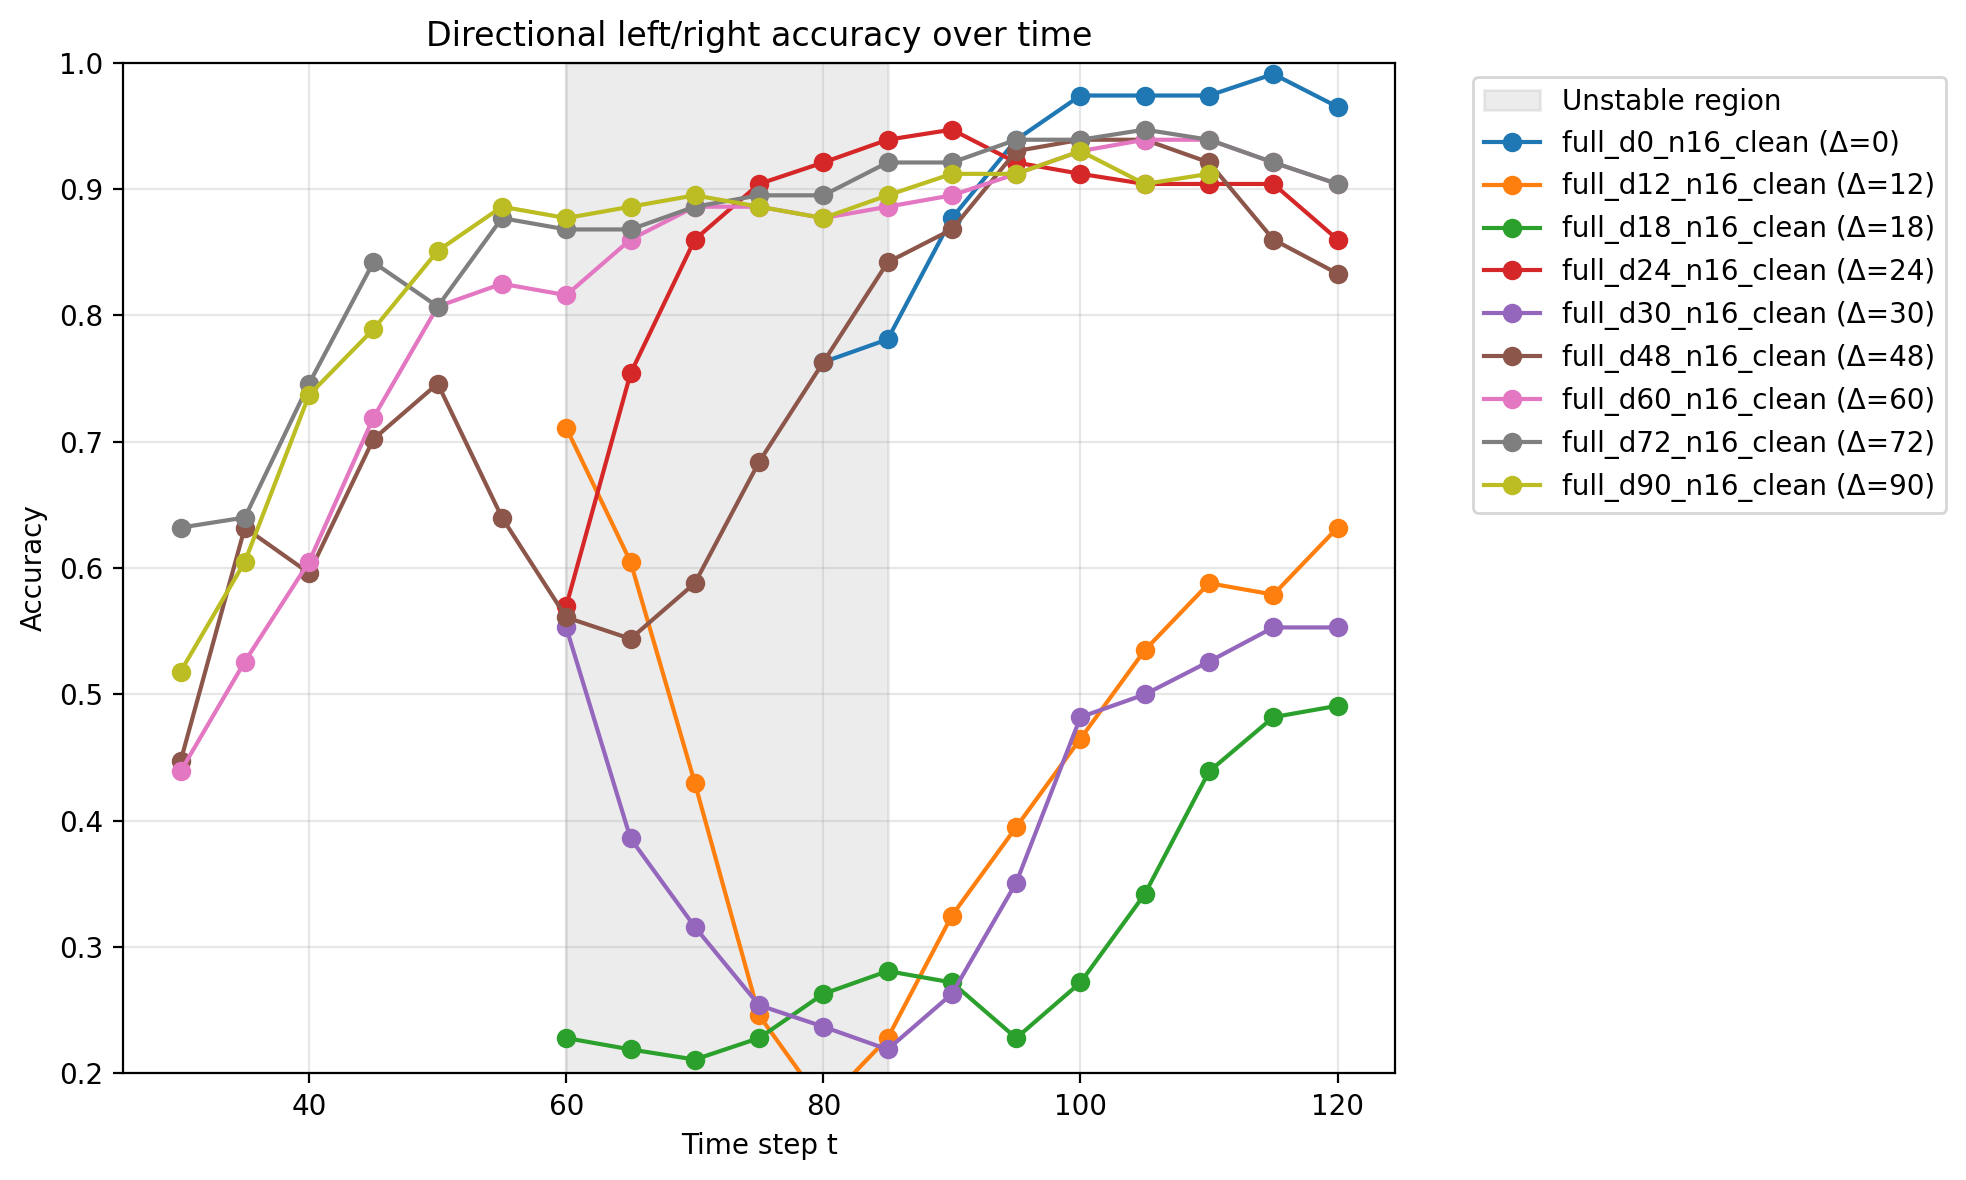

In [8]:
import re
import matplotlib.pyplot as plt

# 1) Paste your full log text here
raw_text = """
➡ Evaluating full_d0_n16_clean (Δ=0) over times [80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d0_n16_clean] t= 80, Δ=  0 | acc_all=0.763 (n=114), acc_strong=1.000 (n_str=1), lowmass=0, ambig=113
[full_d0_n16_clean] t= 85, Δ=  0 | acc_all=0.781 (n=114), acc_strong=1.000 (n_str=16), lowmass=0, ambig=98
[full_d0_n16_clean] t= 90, Δ=  0 | acc_all=0.877 (n=114), acc_strong=1.000 (n_str=40), lowmass=0, ambig=74
[full_d0_n16_clean] t= 95, Δ=  0 | acc_all=0.939 (n=114), acc_strong=1.000 (n_str=69), lowmass=0, ambig=45
[full_d0_n16_clean] t=100, Δ=  0 | acc_all=0.974 (n=114), acc_strong=1.000 (n_str=92), lowmass=0, ambig=22
[full_d0_n16_clean] t=105, Δ=  0 | acc_all=0.974 (n=114), acc_strong=0.990 (n_str=103), lowmass=0, ambig=11
[full_d0_n16_clean] t=110, Δ=  0 | acc_all=0.974 (n=114), acc_strong=0.990 (n_str=104), lowmass=0, ambig=10
[full_d0_n16_clean] t=115, Δ=  0 | acc_all=0.991 (n=114), acc_strong=0.991 (n_str=107), lowmass=0, ambig=7
[full_d0_n16_clean] t=120, Δ=  0 | acc_all=0.965 (n=114), acc_strong=0.972 (n_str=109), lowmass=0, ambig=5
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d6_n16_clean (Δ=6) over times [80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d6_n16_clean] t= 80, Δ=  6 | acc_all=0.307 (n=114), acc_strong=0.400 (n_str=20), lowmass=0, ambig=94
[full_d6_n16_clean] t= 85, Δ=  6 | acc_all=0.351 (n=114), acc_strong=0.311 (n_str=45), lowmass=0, ambig=69
[full_d6_n16_clean] t= 90, Δ=  6 | acc_all=0.342 (n=114), acc_strong=0.364 (n_str=77), lowmass=0, ambig=37
[full_d6_n16_clean] t= 95, Δ=  6 | acc_all=0.395 (n=114), acc_strong=0.385 (n_str=96), lowmass=0, ambig=18
[full_d6_n16_clean] t=100, Δ=  6 | acc_all=0.430 (n=114), acc_strong=0.438 (n_str=105), lowmass=0, ambig=9
[full_d6_n16_clean] t=105, Δ=  6 | acc_all=0.474 (n=114), acc_strong=0.481 (n_str=106), lowmass=0, ambig=8
[full_d6_n16_clean] t=110, Δ=  6 | acc_all=0.491 (n=114), acc_strong=0.523 (n_str=107), lowmass=0, ambig=7
[full_d6_n16_clean] t=115, Δ=  6 | acc_all=0.553 (n=114), acc_strong=0.578 (n_str=109), lowmass=0, ambig=5
[full_d6_n16_clean] t=120, Δ=  6 | acc_all=0.632 (n=114), acc_strong=0.649 (n_str=111), lowmass=0, ambig=3
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d12_n16_clean (Δ=12) over times [60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d12_n16_clean] t= 60, Δ= 12 | acc_all=0.711 (n=114), acc_strong=nan (n_str=0), lowmass=0, ambig=114
[full_d12_n16_clean] t= 65, Δ= 12 | acc_all=0.605 (n=114), acc_strong=0.000 (n_str=1), lowmass=0, ambig=113
[full_d12_n16_clean] t= 70, Δ= 12 | acc_all=0.430 (n=114), acc_strong=0.000 (n_str=4), lowmass=0, ambig=110
[full_d12_n16_clean] t= 75, Δ= 12 | acc_all=0.246 (n=114), acc_strong=0.038 (n_str=26), lowmass=0, ambig=88
[full_d12_n16_clean] t= 80, Δ= 12 | acc_all=0.175 (n=114), acc_strong=0.102 (n_str=49), lowmass=0, ambig=65
[full_d12_n16_clean] t= 85, Δ= 12 | acc_all=0.228 (n=114), acc_strong=0.202 (n_str=84), lowmass=0, ambig=30
[full_d12_n16_clean] t= 90, Δ= 12 | acc_all=0.325 (n=114), acc_strong=0.306 (n_str=98), lowmass=0, ambig=16
[full_d12_n16_clean] t= 95, Δ= 12 | acc_all=0.395 (n=114), acc_strong=0.410 (n_str=105), lowmass=0, ambig=9
[full_d12_n16_clean] t=100, Δ= 12 | acc_all=0.465 (n=114), acc_strong=0.477 (n_str=107), lowmass=0, ambig=7
[full_d12_n16_clean] t=105, Δ= 12 | acc_all=0.535 (n=114), acc_strong=0.551 (n_str=107), lowmass=0, ambig=7
[full_d12_n16_clean] t=110, Δ= 12 | acc_all=0.588 (n=114), acc_strong=0.593 (n_str=108), lowmass=0, ambig=6
[full_d12_n16_clean] t=115, Δ= 12 | acc_all=0.579 (n=114), acc_strong=0.586 (n_str=111), lowmass=0, ambig=3
[full_d12_n16_clean] t=120, Δ= 12 | acc_all=0.632 (n=114), acc_strong=0.636 (n_str=110), lowmass=0, ambig=4
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d18_n16_clean (Δ=18) over times [60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d18_n16_clean] t= 60, Δ= 18 | acc_all=0.228 (n=114), acc_strong=0.000 (n_str=1), lowmass=0, ambig=113
[full_d18_n16_clean] t= 65, Δ= 18 | acc_all=0.219 (n=114), acc_strong=0.000 (n_str=7), lowmass=0, ambig=107
[full_d18_n16_clean] t= 70, Δ= 18 | acc_all=0.211 (n=114), acc_strong=0.094 (n_str=32), lowmass=0, ambig=82
[full_d18_n16_clean] t= 75, Δ= 18 | acc_all=0.228 (n=114), acc_strong=0.089 (n_str=56), lowmass=0, ambig=58
[full_d18_n16_clean] t= 80, Δ= 18 | acc_all=0.263 (n=114), acc_strong=0.184 (n_str=87), lowmass=0, ambig=27
[full_d18_n16_clean] t= 85, Δ= 18 | acc_all=0.281 (n=114), acc_strong=0.260 (n_str=100), lowmass=0, ambig=14
[full_d18_n16_clean] t= 90, Δ= 18 | acc_all=0.272 (n=114), acc_strong=0.255 (n_str=106), lowmass=0, ambig=8
[full_d18_n16_clean] t= 95, Δ= 18 | acc_all=0.228 (n=114), acc_strong=0.196 (n_str=107), lowmass=0, ambig=7
[full_d18_n16_clean] t=100, Δ= 18 | acc_all=0.272 (n=114), acc_strong=0.259 (n_str=108), lowmass=0, ambig=6
[full_d18_n16_clean] t=105, Δ= 18 | acc_all=0.342 (n=114), acc_strong=0.327 (n_str=110), lowmass=0, ambig=4
[full_d18_n16_clean] t=110, Δ= 18 | acc_all=0.439 (n=114), acc_strong=0.432 (n_str=111), lowmass=0, ambig=3
[full_d18_n16_clean] t=115, Δ= 18 | acc_all=0.482 (n=114), acc_strong=0.482 (n_str=110), lowmass=0, ambig=4
[full_d18_n16_clean] t=120, Δ= 18 | acc_all=0.491 (n=114), acc_strong=0.486 (n_str=111), lowmass=0, ambig=3
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d24_n16_clean (Δ=24) over times [60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d24_n16_clean] t= 60, Δ= 24 | acc_all=0.570 (n=114), acc_strong=1.000 (n_str=11), lowmass=0, ambig=103
[full_d24_n16_clean] t= 65, Δ= 24 | acc_all=0.754 (n=114), acc_strong=0.944 (n_str=36), lowmass=0, ambig=78
[full_d24_n16_clean] t= 70, Δ= 24 | acc_all=0.860 (n=114), acc_strong=0.984 (n_str=63), lowmass=0, ambig=51
[full_d24_n16_clean] t= 75, Δ= 24 | acc_all=0.904 (n=114), acc_strong=0.978 (n_str=91), lowmass=0, ambig=23
[full_d24_n16_clean] t= 80, Δ= 24 | acc_all=0.921 (n=114), acc_strong=0.971 (n_str=102), lowmass=0, ambig=12
[full_d24_n16_clean] t= 85, Δ= 24 | acc_all=0.939 (n=114), acc_strong=0.972 (n_str=106), lowmass=0, ambig=8
[full_d24_n16_clean] t= 90, Δ= 24 | acc_all=0.947 (n=114), acc_strong=0.972 (n_str=107), lowmass=0, ambig=7
[full_d24_n16_clean] t= 95, Δ= 24 | acc_all=0.921 (n=114), acc_strong=0.945 (n_str=109), lowmass=0, ambig=5
[full_d24_n16_clean] t=100, Δ= 24 | acc_all=0.912 (n=114), acc_strong=0.936 (n_str=110), lowmass=0, ambig=4
[full_d24_n16_clean] t=105, Δ= 24 | acc_all=0.904 (n=114), acc_strong=0.910 (n_str=111), lowmass=0, ambig=3
[full_d24_n16_clean] t=110, Δ= 24 | acc_all=0.904 (n=114), acc_strong=0.909 (n_str=110), lowmass=0, ambig=4
[full_d24_n16_clean] t=115, Δ= 24 | acc_all=0.904 (n=114), acc_strong=0.910 (n_str=111), lowmass=0, ambig=3
[full_d24_n16_clean] t=120, Δ= 24 | acc_all=0.860 (n=114), acc_strong=0.865 (n_str=111), lowmass=0, ambig=3
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d30_n16_clean (Δ=30) over times [60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d30_n16_clean] t= 60, Δ= 30 | acc_all=0.553 (n=114), acc_strong=0.475 (n_str=40), lowmass=0, ambig=74
[full_d30_n16_clean] t= 65, Δ= 30 | acc_all=0.386 (n=114), acc_strong=0.261 (n_str=69), lowmass=0, ambig=45
[full_d30_n16_clean] t= 70, Δ= 30 | acc_all=0.316 (n=114), acc_strong=0.272 (n_str=92), lowmass=0, ambig=22
[full_d30_n16_clean] t= 75, Δ= 30 | acc_all=0.254 (n=114), acc_strong=0.214 (n_str=103), lowmass=0, ambig=11
[full_d30_n16_clean] t= 80, Δ= 30 | acc_all=0.237 (n=114), acc_strong=0.212 (n_str=104), lowmass=0, ambig=10
[full_d30_n16_clean] t= 85, Δ= 30 | acc_all=0.219 (n=114), acc_strong=0.187 (n_str=107), lowmass=0, ambig=7
[full_d30_n16_clean] t= 90, Δ= 30 | acc_all=0.263 (n=114), acc_strong=0.239 (n_str=109), lowmass=0, ambig=5
[full_d30_n16_clean] t= 95, Δ= 30 | acc_all=0.351 (n=114), acc_strong=0.342 (n_str=111), lowmass=0, ambig=3
[full_d30_n16_clean] t=100, Δ= 30 | acc_all=0.482 (n=114), acc_strong=0.482 (n_str=110), lowmass=0, ambig=4
[full_d30_n16_clean] t=105, Δ= 30 | acc_all=0.500 (n=114), acc_strong=0.495 (n_str=109), lowmass=0, ambig=5
[full_d30_n16_clean] t=110, Δ= 30 | acc_all=0.526 (n=114), acc_strong=0.527 (n_str=110), lowmass=0, ambig=4
[full_d30_n16_clean] t=115, Δ= 30 | acc_all=0.553 (n=114), acc_strong=0.554 (n_str=112), lowmass=0, ambig=2
[full_d30_n16_clean] t=120, Δ= 30 | acc_all=0.553 (n=114), acc_strong=0.554 (n_str=112), lowmass=0, ambig=2
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d36_n16_clean (Δ=36) over times [60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d36_n16_clean] t= 60, Δ= 36 | acc_all=0.658 (n=114), acc_strong=0.792 (n_str=77), lowmass=0, ambig=37
[full_d36_n16_clean] t= 65, Δ= 36 | acc_all=0.781 (n=114), acc_strong=0.844 (n_str=96), lowmass=0, ambig=18
[full_d36_n16_clean] t= 70, Δ= 36 | acc_all=0.860 (n=114), acc_strong=0.905 (n_str=105), lowmass=0, ambig=9
[full_d36_n16_clean] t= 75, Δ= 36 | acc_all=0.912 (n=114), acc_strong=0.953 (n_str=106), lowmass=0, ambig=8
[full_d36_n16_clean] t= 80, Δ= 36 | acc_all=0.904 (n=114), acc_strong=0.944 (n_str=107), lowmass=0, ambig=7
[full_d36_n16_clean] t= 85, Δ= 36 | acc_all=0.930 (n=114), acc_strong=0.945 (n_str=109), lowmass=0, ambig=5
[full_d36_n16_clean] t= 90, Δ= 36 | acc_all=0.947 (n=114), acc_strong=0.964 (n_str=111), lowmass=0, ambig=3
[full_d36_n16_clean] t= 95, Δ= 36 | acc_all=0.947 (n=114), acc_strong=0.973 (n_str=110), lowmass=0, ambig=4
[full_d36_n16_clean] t=100, Δ= 36 | acc_all=0.956 (n=114), acc_strong=0.964 (n_str=110), lowmass=0, ambig=4
[full_d36_n16_clean] t=105, Δ= 36 | acc_all=0.956 (n=114), acc_strong=0.973 (n_str=110), lowmass=0, ambig=4
[full_d36_n16_clean] t=110, Δ= 36 | acc_all=0.965 (n=114), acc_strong=0.973 (n_str=112), lowmass=0, ambig=2
[full_d36_n16_clean] t=115, Δ= 36 | acc_all=0.956 (n=114), acc_strong=0.964 (n_str=112), lowmass=0, ambig=2
[full_d36_n16_clean] t=120, Δ= 36 | acc_all=0.939 (n=114), acc_strong=0.946 (n_str=112), lowmass=0, ambig=2
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d42_n16_clean (Δ=42) over times [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d42_n16_clean] t= 30, Δ= 42 | acc_all=0.219 (n=114), acc_strong=nan (n_str=0), lowmass=0, ambig=114
[full_d42_n16_clean] t= 35, Δ= 42 | acc_all=0.219 (n=114), acc_strong=1.000 (n_str=1), lowmass=0, ambig=113
[full_d42_n16_clean] t= 40, Δ= 42 | acc_all=0.430 (n=114), acc_strong=0.750 (n_str=4), lowmass=0, ambig=110
[full_d42_n16_clean] t= 45, Δ= 42 | acc_all=0.640 (n=114), acc_strong=0.962 (n_str=26), lowmass=0, ambig=88
[full_d42_n16_clean] t= 50, Δ= 42 | acc_all=0.816 (n=114), acc_strong=0.939 (n_str=49), lowmass=0, ambig=65
[full_d42_n16_clean] t= 55, Δ= 42 | acc_all=0.833 (n=114), acc_strong=0.917 (n_str=84), lowmass=0, ambig=30
[full_d42_n16_clean] t= 60, Δ= 42 | acc_all=0.851 (n=114), acc_strong=0.888 (n_str=98), lowmass=0, ambig=16
[full_d42_n16_clean] t= 65, Δ= 42 | acc_all=0.886 (n=114), acc_strong=0.924 (n_str=105), lowmass=0, ambig=9
[full_d42_n16_clean] t= 70, Δ= 42 | acc_all=0.860 (n=114), acc_strong=0.916 (n_str=107), lowmass=0, ambig=7
[full_d42_n16_clean] t= 75, Δ= 42 | acc_all=0.816 (n=114), acc_strong=0.841 (n_str=107), lowmass=0, ambig=7
[full_d42_n16_clean] t= 80, Δ= 42 | acc_all=0.833 (n=114), acc_strong=0.870 (n_str=108), lowmass=0, ambig=6
[full_d42_n16_clean] t= 85, Δ= 42 | acc_all=0.798 (n=114), acc_strong=0.811 (n_str=111), lowmass=0, ambig=3
[full_d42_n16_clean] t= 90, Δ= 42 | acc_all=0.781 (n=114), acc_strong=0.800 (n_str=110), lowmass=0, ambig=4
[full_d42_n16_clean] t= 95, Δ= 42 | acc_all=0.807 (n=114), acc_strong=0.809 (n_str=110), lowmass=0, ambig=4
[full_d42_n16_clean] t=100, Δ= 42 | acc_all=0.781 (n=114), acc_strong=0.791 (n_str=110), lowmass=0, ambig=4
[full_d42_n16_clean] t=105, Δ= 42 | acc_all=0.772 (n=114), acc_strong=0.777 (n_str=112), lowmass=0, ambig=2
[full_d42_n16_clean] t=110, Δ= 42 | acc_all=0.754 (n=114), acc_strong=0.759 (n_str=112), lowmass=0, ambig=2
[full_d42_n16_clean] t=115, Δ= 42 | acc_all=0.781 (n=114), acc_strong=0.786 (n_str=112), lowmass=0, ambig=2
[full_d42_n16_clean] t=120, Δ= 42 | acc_all=0.798 (n=114), acc_strong=0.795 (n_str=112), lowmass=0, ambig=2
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d48_n16_clean (Δ=48) over times [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d48_n16_clean] t= 30, Δ= 48 | acc_all=0.447 (n=114), acc_strong=0.000 (n_str=1), lowmass=0, ambig=113
[full_d48_n16_clean] t= 35, Δ= 48 | acc_all=0.632 (n=114), acc_strong=0.143 (n_str=7), lowmass=0, ambig=107
[full_d48_n16_clean] t= 40, Δ= 48 | acc_all=0.596 (n=114), acc_strong=0.594 (n_str=32), lowmass=0, ambig=82
[full_d48_n16_clean] t= 45, Δ= 48 | acc_all=0.702 (n=114), acc_strong=0.821 (n_str=56), lowmass=0, ambig=58
[full_d48_n16_clean] t= 50, Δ= 48 | acc_all=0.746 (n=114), acc_strong=0.816 (n_str=87), lowmass=0, ambig=27
[full_d48_n16_clean] t= 55, Δ= 48 | acc_all=0.640 (n=114), acc_strong=0.660 (n_str=100), lowmass=0, ambig=14
[full_d48_n16_clean] t= 60, Δ= 48 | acc_all=0.561 (n=114), acc_strong=0.585 (n_str=106), lowmass=0, ambig=8
[full_d48_n16_clean] t= 65, Δ= 48 | acc_all=0.544 (n=114), acc_strong=0.570 (n_str=107), lowmass=0, ambig=7
[full_d48_n16_clean] t= 70, Δ= 48 | acc_all=0.588 (n=114), acc_strong=0.611 (n_str=108), lowmass=0, ambig=6
[full_d48_n16_clean] t= 75, Δ= 48 | acc_all=0.684 (n=114), acc_strong=0.709 (n_str=110), lowmass=0, ambig=4
[full_d48_n16_clean] t= 80, Δ= 48 | acc_all=0.763 (n=114), acc_strong=0.784 (n_str=111), lowmass=0, ambig=3
[full_d48_n16_clean] t= 85, Δ= 48 | acc_all=0.842 (n=114), acc_strong=0.864 (n_str=110), lowmass=0, ambig=4
[full_d48_n16_clean] t= 90, Δ= 48 | acc_all=0.868 (n=114), acc_strong=0.892 (n_str=111), lowmass=0, ambig=3
[full_d48_n16_clean] t= 95, Δ= 48 | acc_all=0.930 (n=114), acc_strong=0.945 (n_str=110), lowmass=0, ambig=4
[full_d48_n16_clean] t=100, Δ= 48 | acc_all=0.939 (n=114), acc_strong=0.955 (n_str=112), lowmass=0, ambig=2
[full_d48_n16_clean] t=105, Δ= 48 | acc_all=0.939 (n=114), acc_strong=0.955 (n_str=112), lowmass=0, ambig=2
[full_d48_n16_clean] t=110, Δ= 48 | acc_all=0.921 (n=114), acc_strong=0.929 (n_str=112), lowmass=0, ambig=2
[full_d48_n16_clean] t=115, Δ= 48 | acc_all=0.860 (n=114), acc_strong=0.875 (n_str=112), lowmass=0, ambig=2
[full_d48_n16_clean] t=120, Δ= 48 | acc_all=0.833 (n=114), acc_strong=0.838 (n_str=111), lowmass=0, ambig=3
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d54_n16_clean (Δ=54) over times [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d54_n16_clean] t= 30, Δ= 54 | acc_all=0.667 (n=114), acc_strong=0.545 (n_str=11), lowmass=0, ambig=103
[full_d54_n16_clean] t= 35, Δ= 54 | acc_all=0.570 (n=114), acc_strong=0.694 (n_str=36), lowmass=0, ambig=78
[full_d54_n16_clean] t= 40, Δ= 54 | acc_all=0.570 (n=114), acc_strong=0.683 (n_str=63), lowmass=0, ambig=51
[full_d54_n16_clean] t= 45, Δ= 54 | acc_all=0.719 (n=114), acc_strong=0.791 (n_str=91), lowmass=0, ambig=23
[full_d54_n16_clean] t= 50, Δ= 54 | acc_all=0.816 (n=114), acc_strong=0.863 (n_str=102), lowmass=0, ambig=12
[full_d54_n16_clean] t= 55, Δ= 54 | acc_all=0.833 (n=114), acc_strong=0.858 (n_str=106), lowmass=0, ambig=8
[full_d54_n16_clean] t= 60, Δ= 54 | acc_all=0.860 (n=114), acc_strong=0.888 (n_str=107), lowmass=0, ambig=7
[full_d54_n16_clean] t= 65, Δ= 54 | acc_all=0.877 (n=114), acc_strong=0.908 (n_str=109), lowmass=0, ambig=5
[full_d54_n16_clean] t= 70, Δ= 54 | acc_all=0.912 (n=114), acc_strong=0.936 (n_str=110), lowmass=0, ambig=4
[full_d54_n16_clean] t= 75, Δ= 54 | acc_all=0.930 (n=114), acc_strong=0.955 (n_str=111), lowmass=0, ambig=3
[full_d54_n16_clean] t= 80, Δ= 54 | acc_all=0.930 (n=114), acc_strong=0.955 (n_str=110), lowmass=0, ambig=4
[full_d54_n16_clean] t= 85, Δ= 54 | acc_all=0.921 (n=114), acc_strong=0.946 (n_str=111), lowmass=0, ambig=3
[full_d54_n16_clean] t= 90, Δ= 54 | acc_all=0.921 (n=114), acc_strong=0.928 (n_str=111), lowmass=0, ambig=3
[full_d54_n16_clean] t= 95, Δ= 54 | acc_all=0.921 (n=114), acc_strong=0.929 (n_str=112), lowmass=0, ambig=2
[full_d54_n16_clean] t=100, Δ= 54 | acc_all=0.921 (n=114), acc_strong=0.929 (n_str=112), lowmass=0, ambig=2
[full_d54_n16_clean] t=105, Δ= 54 | acc_all=0.939 (n=114), acc_strong=0.946 (n_str=112), lowmass=0, ambig=2
[full_d54_n16_clean] t=110, Δ= 54 | acc_all=0.939 (n=114), acc_strong=0.946 (n_str=112), lowmass=0, ambig=2
[full_d54_n16_clean] t=115, Δ= 54 | acc_all=0.930 (n=114), acc_strong=0.937 (n_str=111), lowmass=0, ambig=3
[full_d54_n16_clean] t=120, Δ= 54 | acc_all=0.921 (n=114), acc_strong=0.936 (n_str=110), lowmass=0, ambig=4
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d60_n16_clean (Δ=60) over times [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d60_n16_clean] t= 30, Δ= 60 | acc_all=0.439 (n=114), acc_strong=0.425 (n_str=40), lowmass=0, ambig=74
[full_d60_n16_clean] t= 35, Δ= 60 | acc_all=0.526 (n=114), acc_strong=0.580 (n_str=69), lowmass=0, ambig=45
[full_d60_n16_clean] t= 40, Δ= 60 | acc_all=0.605 (n=114), acc_strong=0.652 (n_str=92), lowmass=0, ambig=22
[full_d60_n16_clean] t= 45, Δ= 60 | acc_all=0.719 (n=114), acc_strong=0.767 (n_str=103), lowmass=0, ambig=11
[full_d60_n16_clean] t= 50, Δ= 60 | acc_all=0.807 (n=114), acc_strong=0.856 (n_str=104), lowmass=0, ambig=10
[full_d60_n16_clean] t= 55, Δ= 60 | acc_all=0.825 (n=114), acc_strong=0.860 (n_str=107), lowmass=0, ambig=7
[full_d60_n16_clean] t= 60, Δ= 60 | acc_all=0.816 (n=114), acc_strong=0.844 (n_str=109), lowmass=0, ambig=5
[full_d60_n16_clean] t= 65, Δ= 60 | acc_all=0.860 (n=114), acc_strong=0.883 (n_str=111), lowmass=0, ambig=3
[full_d60_n16_clean] t= 70, Δ= 60 | acc_all=0.886 (n=114), acc_strong=0.909 (n_str=110), lowmass=0, ambig=4
[full_d60_n16_clean] t= 75, Δ= 60 | acc_all=0.886 (n=114), acc_strong=0.908 (n_str=109), lowmass=0, ambig=5
[full_d60_n16_clean] t= 80, Δ= 60 | acc_all=0.877 (n=114), acc_strong=0.900 (n_str=110), lowmass=0, ambig=4
[full_d60_n16_clean] t= 85, Δ= 60 | acc_all=0.886 (n=114), acc_strong=0.902 (n_str=112), lowmass=0, ambig=2
[full_d60_n16_clean] t= 90, Δ= 60 | acc_all=0.895 (n=114), acc_strong=0.911 (n_str=112), lowmass=0, ambig=2
[full_d60_n16_clean] t= 95, Δ= 60 | acc_all=0.912 (n=114), acc_strong=0.929 (n_str=112), lowmass=0, ambig=2
[full_d60_n16_clean] t=100, Δ= 60 | acc_all=0.930 (n=114), acc_strong=0.946 (n_str=112), lowmass=0, ambig=2
[full_d60_n16_clean] t=105, Δ= 60 | acc_all=0.939 (n=114), acc_strong=0.955 (n_str=112), lowmass=0, ambig=2
[full_d60_n16_clean] t=110, Δ= 60 | acc_all=0.939 (n=114), acc_strong=0.955 (n_str=111), lowmass=0, ambig=3
[full_d60_n16_clean] t=115, Δ= 60 | acc_all=0.921 (n=114), acc_strong=0.945 (n_str=109), lowmass=0, ambig=5
[full_d60_n16_clean] t=120, Δ= 60 | acc_all=0.904 (n=114), acc_strong=0.926 (n_str=108), lowmass=0, ambig=6
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d66_n16_clean (Δ=66) over times [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d66_n16_clean] t= 30, Δ= 66 | acc_all=0.342 (n=114), acc_strong=0.364 (n_str=77), lowmass=0, ambig=37
[full_d66_n16_clean] t= 35, Δ= 66 | acc_all=0.360 (n=114), acc_strong=0.344 (n_str=96), lowmass=0, ambig=18
[full_d66_n16_clean] t= 40, Δ= 66 | acc_all=0.360 (n=114), acc_strong=0.362 (n_str=105), lowmass=0, ambig=9
[full_d66_n16_clean] t= 45, Δ= 66 | acc_all=0.360 (n=114), acc_strong=0.368 (n_str=106), lowmass=0, ambig=8
[full_d66_n16_clean] t= 50, Δ= 66 | acc_all=0.360 (n=114), acc_strong=0.374 (n_str=107), lowmass=0, ambig=7
[full_d66_n16_clean] t= 55, Δ= 66 | acc_all=0.360 (n=114), acc_strong=0.367 (n_str=109), lowmass=0, ambig=5
[full_d66_n16_clean] t= 60, Δ= 66 | acc_all=0.360 (n=114), acc_strong=0.369 (n_str=111), lowmass=0, ambig=3
[full_d66_n16_clean] t= 65, Δ= 66 | acc_all=0.360 (n=114), acc_strong=0.364 (n_str=110), lowmass=0, ambig=4
[full_d66_n16_clean] t= 70, Δ= 66 | acc_all=0.360 (n=114), acc_strong=0.355 (n_str=110), lowmass=0, ambig=4
[full_d66_n16_clean] t= 75, Δ= 66 | acc_all=0.351 (n=114), acc_strong=0.364 (n_str=110), lowmass=0, ambig=4
[full_d66_n16_clean] t= 80, Δ= 66 | acc_all=0.368 (n=114), acc_strong=0.375 (n_str=112), lowmass=0, ambig=2
[full_d66_n16_clean] t= 85, Δ= 66 | acc_all=0.368 (n=114), acc_strong=0.375 (n_str=112), lowmass=0, ambig=2
[full_d66_n16_clean] t= 90, Δ= 66 | acc_all=0.368 (n=114), acc_strong=0.375 (n_str=112), lowmass=0, ambig=2
[full_d66_n16_clean] t= 95, Δ= 66 | acc_all=0.377 (n=114), acc_strong=0.384 (n_str=112), lowmass=0, ambig=2
[full_d66_n16_clean] t=100, Δ= 66 | acc_all=0.386 (n=114), acc_strong=0.393 (n_str=112), lowmass=0, ambig=2
[full_d66_n16_clean] t=105, Δ= 66 | acc_all=0.404 (n=114), acc_strong=0.405 (n_str=111), lowmass=0, ambig=3
[full_d66_n16_clean] t=110, Δ= 66 | acc_all=0.386 (n=114), acc_strong=0.398 (n_str=108), lowmass=0, ambig=6
[full_d66_n16_clean] t=115, Δ= 66 | acc_all=0.386 (n=114), acc_strong=0.402 (n_str=107), lowmass=0, ambig=7
[full_d66_n16_clean] t=120, Δ= 66 | acc_all=0.395 (n=114), acc_strong=0.411 (n_str=107), lowmass=0, ambig=7
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d72_n16_clean (Δ=72) over times [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d72_n16_clean] t= 30, Δ= 72 | acc_all=0.632 (n=114), acc_strong=0.663 (n_str=98), lowmass=0, ambig=16
[full_d72_n16_clean] t= 35, Δ= 72 | acc_all=0.640 (n=114), acc_strong=0.638 (n_str=105), lowmass=0, ambig=9
[full_d72_n16_clean] t= 40, Δ= 72 | acc_all=0.746 (n=114), acc_strong=0.738 (n_str=107), lowmass=0, ambig=7
[full_d72_n16_clean] t= 45, Δ= 72 | acc_all=0.842 (n=114), acc_strong=0.850 (n_str=107), lowmass=0, ambig=7
[full_d72_n16_clean] t= 50, Δ= 72 | acc_all=0.807 (n=114), acc_strong=0.824 (n_str=108), lowmass=0, ambig=6
[full_d72_n16_clean] t= 55, Δ= 72 | acc_all=0.877 (n=114), acc_strong=0.901 (n_str=111), lowmass=0, ambig=3
[full_d72_n16_clean] t= 60, Δ= 72 | acc_all=0.868 (n=114), acc_strong=0.891 (n_str=110), lowmass=0, ambig=4
[full_d72_n16_clean] t= 65, Δ= 72 | acc_all=0.868 (n=114), acc_strong=0.882 (n_str=110), lowmass=0, ambig=4
[full_d72_n16_clean] t= 70, Δ= 72 | acc_all=0.886 (n=114), acc_strong=0.918 (n_str=110), lowmass=0, ambig=4
[full_d72_n16_clean] t= 75, Δ= 72 | acc_all=0.895 (n=114), acc_strong=0.911 (n_str=112), lowmass=0, ambig=2
[full_d72_n16_clean] t= 80, Δ= 72 | acc_all=0.895 (n=114), acc_strong=0.911 (n_str=112), lowmass=0, ambig=2
[full_d72_n16_clean] t= 85, Δ= 72 | acc_all=0.921 (n=114), acc_strong=0.938 (n_str=112), lowmass=0, ambig=2
[full_d72_n16_clean] t= 90, Δ= 72 | acc_all=0.921 (n=114), acc_strong=0.938 (n_str=112), lowmass=0, ambig=2
[full_d72_n16_clean] t= 95, Δ= 72 | acc_all=0.939 (n=114), acc_strong=0.955 (n_str=111), lowmass=0, ambig=3
[full_d72_n16_clean] t=100, Δ= 72 | acc_all=0.939 (n=114), acc_strong=0.955 (n_str=110), lowmass=0, ambig=4
[full_d72_n16_clean] t=105, Δ= 72 | acc_all=0.947 (n=114), acc_strong=0.963 (n_str=108), lowmass=0, ambig=6
[full_d72_n16_clean] t=110, Δ= 72 | acc_all=0.939 (n=114), acc_strong=0.963 (n_str=107), lowmass=0, ambig=7
[full_d72_n16_clean] t=115, Δ= 72 | acc_all=0.921 (n=114), acc_strong=0.963 (n_str=107), lowmass=0, ambig=7
[full_d72_n16_clean] t=120, Δ= 72 | acc_all=0.904 (n=114), acc_strong=0.935 (n_str=108), lowmass=0, ambig=6
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d78_n16_clean (Δ=78) over times [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d78_n16_clean] t= 30, Δ= 78 | acc_all=0.640 (n=114), acc_strong=0.642 (n_str=106), lowmass=0, ambig=8
[full_d78_n16_clean] t= 35, Δ= 78 | acc_all=0.640 (n=114), acc_strong=0.626 (n_str=107), lowmass=0, ambig=7
[full_d78_n16_clean] t= 40, Δ= 78 | acc_all=0.640 (n=114), acc_strong=0.630 (n_str=108), lowmass=0, ambig=6
[full_d78_n16_clean] t= 45, Δ= 78 | acc_all=0.640 (n=114), acc_strong=0.627 (n_str=110), lowmass=0, ambig=4
[full_d78_n16_clean] t= 50, Δ= 78 | acc_all=0.640 (n=114), acc_strong=0.631 (n_str=111), lowmass=0, ambig=3
[full_d78_n16_clean] t= 55, Δ= 78 | acc_all=0.640 (n=114), acc_strong=0.636 (n_str=110), lowmass=0, ambig=4
[full_d78_n16_clean] t= 60, Δ= 78 | acc_all=0.649 (n=114), acc_strong=0.640 (n_str=111), lowmass=0, ambig=3
[full_d78_n16_clean] t= 65, Δ= 78 | acc_all=0.632 (n=114), acc_strong=0.636 (n_str=110), lowmass=0, ambig=4
[full_d78_n16_clean] t= 70, Δ= 78 | acc_all=0.632 (n=114), acc_strong=0.625 (n_str=112), lowmass=0, ambig=2
[full_d78_n16_clean] t= 75, Δ= 78 | acc_all=0.632 (n=114), acc_strong=0.625 (n_str=112), lowmass=0, ambig=2
[full_d78_n16_clean] t= 80, Δ= 78 | acc_all=0.632 (n=114), acc_strong=0.625 (n_str=112), lowmass=0, ambig=2
[full_d78_n16_clean] t= 85, Δ= 78 | acc_all=0.623 (n=114), acc_strong=0.616 (n_str=112), lowmass=0, ambig=2
[full_d78_n16_clean] t= 90, Δ= 78 | acc_all=0.605 (n=114), acc_strong=0.604 (n_str=111), lowmass=0, ambig=3
[full_d78_n16_clean] t= 95, Δ= 78 | acc_all=0.535 (n=114), acc_strong=0.527 (n_str=110), lowmass=0, ambig=4
[full_d78_n16_clean] t=100, Δ= 78 | acc_all=0.474 (n=114), acc_strong=0.454 (n_str=108), lowmass=0, ambig=6
[full_d78_n16_clean] t=105, Δ= 78 | acc_all=0.465 (n=114), acc_strong=0.449 (n_str=107), lowmass=0, ambig=7
[full_d78_n16_clean] t=110, Δ= 78 | acc_all=0.474 (n=114), acc_strong=0.458 (n_str=107), lowmass=0, ambig=7
[full_d78_n16_clean] t=115, Δ= 78 | acc_all=0.456 (n=114), acc_strong=0.454 (n_str=108), lowmass=0, ambig=6
[full_d78_n16_clean] t=120, Δ= 78 | acc_all=0.439 (n=114), acc_strong=0.435 (n_str=108), lowmass=0, ambig=6
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d84_n16_clean (Δ=84) over times [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d84_n16_clean] t= 30, Δ= 84 | acc_all=0.632 (n=114), acc_strong=0.626 (n_str=107), lowmass=0, ambig=7
[full_d84_n16_clean] t= 35, Δ= 84 | acc_all=0.640 (n=114), acc_strong=0.633 (n_str=109), lowmass=0, ambig=5
[full_d84_n16_clean] t= 40, Δ= 84 | acc_all=0.640 (n=114), acc_strong=0.627 (n_str=110), lowmass=0, ambig=4
[full_d84_n16_clean] t= 45, Δ= 84 | acc_all=0.640 (n=114), acc_strong=0.631 (n_str=111), lowmass=0, ambig=3
[full_d84_n16_clean] t= 50, Δ= 84 | acc_all=0.640 (n=114), acc_strong=0.636 (n_str=110), lowmass=0, ambig=4
[full_d84_n16_clean] t= 55, Δ= 84 | acc_all=0.649 (n=114), acc_strong=0.640 (n_str=111), lowmass=0, ambig=3
[full_d84_n16_clean] t= 60, Δ= 84 | acc_all=0.632 (n=114), acc_strong=0.631 (n_str=111), lowmass=0, ambig=3
[full_d84_n16_clean] t= 65, Δ= 84 | acc_all=0.632 (n=114), acc_strong=0.625 (n_str=112), lowmass=0, ambig=2
[full_d84_n16_clean] t= 70, Δ= 84 | acc_all=0.640 (n=114), acc_strong=0.634 (n_str=112), lowmass=0, ambig=2
[full_d84_n16_clean] t= 75, Δ= 84 | acc_all=0.658 (n=114), acc_strong=0.652 (n_str=112), lowmass=0, ambig=2
[full_d84_n16_clean] t= 80, Δ= 84 | acc_all=0.684 (n=114), acc_strong=0.679 (n_str=112), lowmass=0, ambig=2
[full_d84_n16_clean] t= 85, Δ= 84 | acc_all=0.702 (n=114), acc_strong=0.703 (n_str=111), lowmass=0, ambig=3
[full_d84_n16_clean] t= 90, Δ= 84 | acc_all=0.719 (n=114), acc_strong=0.718 (n_str=110), lowmass=0, ambig=4
[full_d84_n16_clean] t= 95, Δ= 84 | acc_all=0.711 (n=114), acc_strong=0.704 (n_str=108), lowmass=0, ambig=6
[full_d84_n16_clean] t=100, Δ= 84 | acc_all=0.754 (n=114), acc_strong=0.748 (n_str=107), lowmass=0, ambig=7
[full_d84_n16_clean] t=105, Δ= 84 | acc_all=0.719 (n=114), acc_strong=0.729 (n_str=107), lowmass=0, ambig=7
[full_d84_n16_clean] t=110, Δ= 84 | acc_all=0.711 (n=114), acc_strong=0.722 (n_str=108), lowmass=0, ambig=6
[full_d84_n16_clean] t=115, Δ= 84 | acc_all=0.667 (n=114), acc_strong=0.676 (n_str=108), lowmass=0, ambig=6
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d90_n16_clean (Δ=90) over times [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d90_n16_clean] t= 30, Δ= 90 | acc_all=0.518 (n=114), acc_strong=0.505 (n_str=109), lowmass=0, ambig=5
[full_d90_n16_clean] t= 35, Δ= 90 | acc_all=0.605 (n=114), acc_strong=0.613 (n_str=111), lowmass=0, ambig=3
[full_d90_n16_clean] t= 40, Δ= 90 | acc_all=0.737 (n=114), acc_strong=0.755 (n_str=110), lowmass=0, ambig=4
[full_d90_n16_clean] t= 45, Δ= 90 | acc_all=0.789 (n=114), acc_strong=0.817 (n_str=109), lowmass=0, ambig=5
[full_d90_n16_clean] t= 50, Δ= 90 | acc_all=0.851 (n=114), acc_strong=0.873 (n_str=110), lowmass=0, ambig=4
[full_d90_n16_clean] t= 55, Δ= 90 | acc_all=0.886 (n=114), acc_strong=0.902 (n_str=112), lowmass=0, ambig=2
[full_d90_n16_clean] t= 60, Δ= 90 | acc_all=0.877 (n=114), acc_strong=0.893 (n_str=112), lowmass=0, ambig=2
[full_d90_n16_clean] t= 65, Δ= 90 | acc_all=0.886 (n=114), acc_strong=0.902 (n_str=112), lowmass=0, ambig=2
[full_d90_n16_clean] t= 70, Δ= 90 | acc_all=0.895 (n=114), acc_strong=0.911 (n_str=112), lowmass=0, ambig=2
[full_d90_n16_clean] t= 75, Δ= 90 | acc_all=0.886 (n=114), acc_strong=0.902 (n_str=112), lowmass=0, ambig=2
[full_d90_n16_clean] t= 80, Δ= 90 | acc_all=0.877 (n=114), acc_strong=0.892 (n_str=111), lowmass=0, ambig=3
[full_d90_n16_clean] t= 85, Δ= 90 | acc_all=0.895 (n=114), acc_strong=0.908 (n_str=109), lowmass=0, ambig=5
[full_d90_n16_clean] t= 90, Δ= 90 | acc_all=0.912 (n=114), acc_strong=0.935 (n_str=108), lowmass=0, ambig=6
[full_d90_n16_clean] t= 95, Δ= 90 | acc_all=0.912 (n=114), acc_strong=0.944 (n_str=107), lowmass=0, ambig=7
[full_d90_n16_clean] t=100, Δ= 90 | acc_all=0.930 (n=114), acc_strong=0.963 (n_str=107), lowmass=0, ambig=7
[full_d90_n16_clean] t=105, Δ= 90 | acc_all=0.904 (n=114), acc_strong=0.935 (n_str=108), lowmass=0, ambig=6
[full_d90_n16_clean] t=110, Δ= 90 | acc_all=0.912 (n=114), acc_strong=0.935 (n_str=108), lowmass=0, ambig=6
Done. Accuracy summary: See metrics output
--------------------------------------------------
➡ Evaluating full_d96_n16_clean (Δ=96) over times [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
[full_d96_n16_clean] t= 30, Δ= 96 | acc_all=0.640 (n=114), acc_strong=0.631 (n_str=111), lowmass=0, ambig=3
[full_d96_n16_clean] t= 35, Δ= 96 | acc_all=0.640 (n=114), acc_strong=0.636 (n_str=110), lowmass=0, ambig=4
[full_d96_n16_clean] t= 40, Δ= 96 | acc_all=0.640 (n=114), acc_strong=0.645 (n_str=110), lowmass=0, ambig=4
[full_d96_n16_clean] t= 45, Δ= 96 | acc_all=0.649 (n=114), acc_strong=0.636 (n_str=110), lowmass=0, ambig=4
[full_d96_n16_clean] t= 50, Δ= 96 | acc_all=0.632 (n=114), acc_strong=0.625 (n_str=112), lowmass=0, ambig=2
[full_d96_n16_clean] t= 55, Δ= 96 | acc_all=0.632 (n=114), acc_strong=0.625 (n_str=112), lowmass=0, ambig=2
[full_d96_n16_clean] t= 60, Δ= 96 | acc_all=0.632 (n=114), acc_strong=0.625 (n_str=112), lowmass=0, ambig=2
[full_d96_n16_clean] t= 65, Δ= 96 | acc_all=0.632 (n=114), acc_strong=0.625 (n_str=112), lowmass=0, ambig=2
[full_d96_n16_clean] t= 70, Δ= 96 | acc_all=0.632 (n=114), acc_strong=0.625 (n_str=112), lowmass=0, ambig=2
[full_d96_n16_clean] t= 75, Δ= 96 | acc_all=0.632 (n=114), acc_strong=0.631 (n_str=111), lowmass=0, ambig=3
[full_d96_n16_clean] t= 80, Δ= 96 | acc_all=0.632 (n=114), acc_strong=0.620 (n_str=108), lowmass=0, ambig=6
[full_d96_n16_clean] t= 85, Δ= 96 | acc_all=0.640 (n=114), acc_strong=0.626 (n_str=107), lowmass=0, ambig=7
[full_d96_n16_clean] t= 90, Δ= 96 | acc_all=0.649 (n=114), acc_strong=0.636 (n_str=107), lowmass=0, ambig=7
[full_d96_n16_clean] t= 95, Δ= 96 | acc_all=0.649 (n=114), acc_strong=0.645 (n_str=107), lowmass=0, ambig=7
[full_d96_n16_clean] t=100, Δ= 96 | acc_all=0.640 (n=114), acc_strong=0.648 (n_str=108), lowmass=0, ambig=6
Done. Accuracy summary: See metrics output
--------------------------------------------------
🚫 Skipping full_d102_n16_clean — model file not found (full_d102_n16_clean.pt)
🚫 Skipping full_d108_n16_clean — model file not found (full_d108_n16_clean.pt)
🚫 Skipping full_d114_n16_clean — model file not found (full_d114_n16_clean.pt)
🚫 Skipping full_d120_n16_clean — model file not found (full_d120_n16_clean.pt)
🚫 Skipping full_d126_n16_clean — model file not found (full_d126_n16_clean.pt)
🚫 Skipping full_d132_n16_clean — model file not found (full_d132_n16_clean.pt)
🚫 Skipping full_d138_n16_clean — model file not found (full_d138_n16_clean.pt)
"""

# 2) Parse the text into a metrics dict
metrics = {}  # model_name -> {"delta": int, "t": [...], "acc_all": [...]}
current_model = None

for line in raw_text.splitlines():
    # Header line: "➡ Evaluating full_d0_n16_clean (Δ=0) over times ..."
    header_match = re.search(r"Evaluating (\w+) \(Δ=(\d+)\)", line)
    if header_match:
        model_name = header_match.group(1)
        delta = int(header_match.group(2))
        metrics[model_name] = {"delta": delta, "t": [], "acc_all": []}
        current_model = model_name
        continue

    # Data line: "[full_d0_n16_clean] t= 80, Δ=  0 | acc_all=0.763 ..."
    if current_model is not None and "acc_all=" in line:
        m = re.search(r"t=\s*(\d+).*?acc_all=([0-9.]+)", line)
        if m:
            t = int(m.group(1))
            acc = float(m.group(2))
            metrics[current_model]["t"].append(t)
            metrics[current_model]["acc_all"].append(acc)

# 3) Choose which models to plot (keep this small so it’s readable)
selected_models = [
    "full_d0_n16_clean",
    "full_d12_n16_clean",
    "full_d18_n16_clean",
    "full_d24_n16_clean",
    "full_d30_n16_clean",
    "full_d48_n16_clean",
    "full_d60_n16_clean",
    "full_d72_n16_clean",
    "full_d90_n16_clean",
]

# 4) Plot
plt.figure(figsize=(10, 6), dpi=200)

# shaded “decision/uncertainty” region (adjust bounds if you want)
plt.axvspan(60, 85, alpha=0.15, color="gray", label="Unstable region")

for name, info in metrics.items():
    if name not in selected_models:
        continue
    t_vals = info["t"]
    acc_vals = info["acc_all"]
    Δ = info["delta"]
    label = f"{name} (Δ={Δ})"
    plt.plot(t_vals, acc_vals, marker="o", linewidth=1.5, label=label)

plt.title("Directional left/right accuracy over time")
plt.xlabel("Time step t")
plt.ylabel("Accuracy")
plt.ylim(0.2, 1.0)
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()